In [1]:
import pickle
import numpy as np
import torch

In [2]:
import matplotlib.pyplot as plt

In [3]:
with open('CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,0.00,1)_L(8,10,2)_xj(0)_seed0_64_wf.pickle','rb') as f:
    wf = pickle.load(f)

In [4]:
with open('CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,0.00,1)_L(8,10,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wf2 = pickle.load(f)

In [5]:
with open('CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,0.00,1)_L(12,14,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wf3 = pickle.load(f)

In [6]:
with open('CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,0.00,1)_L(14,16,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wf4 = pickle.load(f)

In [7]:
with open('CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,0.00,1)_L(16,18,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wf5 = pickle.load(f)

In [11]:
with open('CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,1.00,21)_L(8,10,2)_xj(0)_seed0_64_wf.pickle','rb') as f:
    wfs_0_8 = pickle.load(f)
with open('CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,1.00,21)_L(12,14,2)_xj(0)_seed0_64_wf.pickle','rb') as f:
    wfs_0_12 = pickle.load(f)

In [ ]:
with open('CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,1.00,21)_L(8,10,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wfs_1_3_8 = pickle.load(f)
with open('CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,1.00,21)_L(10,12,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wfs_1_3_10 = pickle.load(f)
with open('CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,1.00,21)_L(12,14,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wfs_1_3_12 = pickle.load(f)

In [9]:
def convert_tensor(wf,grid=21,kmax=-1):
    wf=torch.stack(wf)
    wf=wf.reshape((grid,grid)+wf.shape[1:])
    wf=torch.mean(torch.abs(wf[...,:kmax,:])**2,axis=(-2,-1)).reshape((grid,grid,-1))
    return wf
    

In [12]:
wfs_0_8_dist=convert_tensor(wfs_0_8)
wfs_0_12_dist=convert_tensor(wfs_0_12)

In [152]:
wfs_0_12_dist_half=convert_tensor(wfs_0_12,kmax=1000)
wfs_0_12_dist_quarter=convert_tensor(wfs_0_12,kmax=500)

In [9]:
wfs_1_3_8_dist=convert_tensor(wfs_1_3_8)
wfs_1_3_10_dist=convert_tensor(wfs_1_3_10)
wfs_1_3_12_dist=convert_tensor(wfs_1_3_12)

In [14]:
wfs_0_tensor=torch.stack(wfs_0)

In [15]:
wfs_tensor=torch.stack(wfs)

In [16]:
torch.where(torch.isnan(wfs_0_tensor))

(tensor([216, 216, 216,  ..., 373, 373, 373]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([0, 0, 1,  ..., 0, 1, 1]),
 tensor([0, 1, 0,  ..., 1, 0, 1]),
 tensor([1642, 1642, 1642,  ...,  980,  980,  980]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [17]:
230//21,230%21

(10, 20)

In [18]:
wfs_all=wfs_tensor.reshape((21,21)+wfs_tensor.shape[1:])

In [19]:
wfs_0_all=wfs_0_tensor.reshape((21,21)+wfs_0_tensor.shape[1:])

In [20]:
dist=(torch.abs(wf[0])**2).mean(axis=(-2,-1)).flatten()

In [21]:
dist2=(torch.abs(wf2[0])**2).mean(axis=(-2,-1)).flatten()

In [22]:
dist3=(torch.abs(wf3[0])**2).mean(axis=(-2,-1)).flatten()

In [23]:
dist4=(torch.abs(wf4[0])**2).mean(axis=(-2,-1)).flatten()

In [24]:
dist5=(torch.abs(wf5[0])**2).mean(axis=(-2,-1)).flatten()

In [25]:
wfs_all.shape

torch.Size([21, 21, 2, 2, 2, 2, 2, 2, 2, 2, 2000, 1])

In [26]:
wfs_dist=torch.mean(torch.abs(wfs_all)**2,axis=(-2,-1)).reshape((21,21,-1))

In [27]:
wfs_0_dist=torch.mean(torch.abs(wfs_0_all)**2,axis=(-2,-1)).reshape((21,21,-1))

In [28]:
plt.pcolormesh(np.linspace(0,1,21),np.linspace(0,1,21),wfs_dist[:,:,256//3])
plt.colorbar()

NameError: name 'plt' is not defined

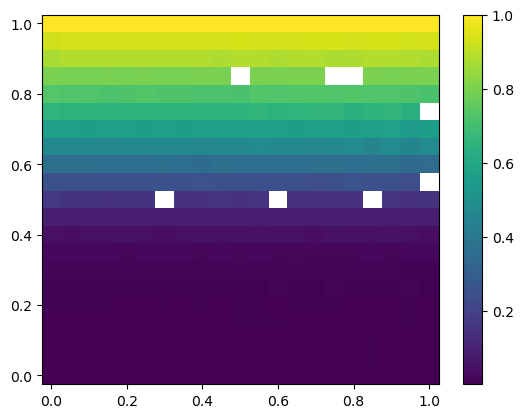

In [30]:
plt.pcolormesh(np.linspace(0,1,21),np.linspace(0,1,21),wfs_0_dist[:,:,0])
plt.colorbar()

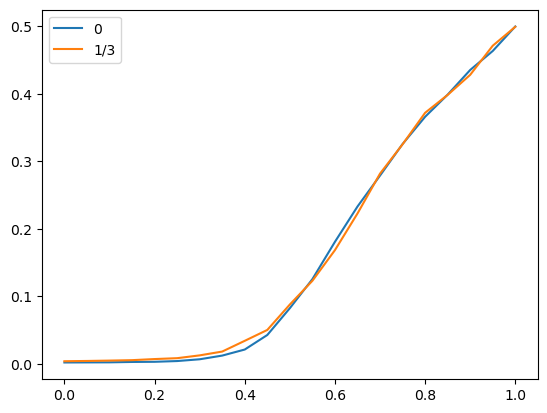

In [31]:
plt.plot(np.linspace(0,1,21),wfs_0_dist[:,0,0]/2,label='0')
plt.plot(np.linspace(0,1,21),wfs_dist[:,0,256//3],label='1/3')
plt.legend()

In [ ]:
wfs_dist[:,:,256//3]

In [33]:
wfs_dist.shape

torch.Size([21, 21, 256])

In [39]:
2**(-wfs_dist.shape[-1])

8.636168555094445e-78

(0.0, 1.1)

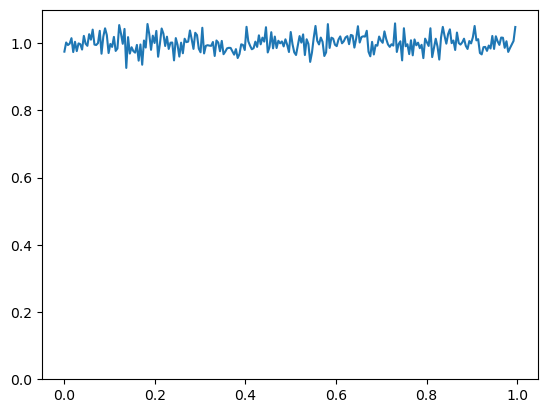

In [48]:
plt.plot(np.arange(0,1,1/(wfs_dist.shape[-1])),wfs_dist[0,0]*(wfs_dist.shape[-1]))
# plt.plot(x,wfs_dist[10,15])
plt.ylim(0,1.1)

In [23]:
x=np.linspace(0,1,dist.shape[0])


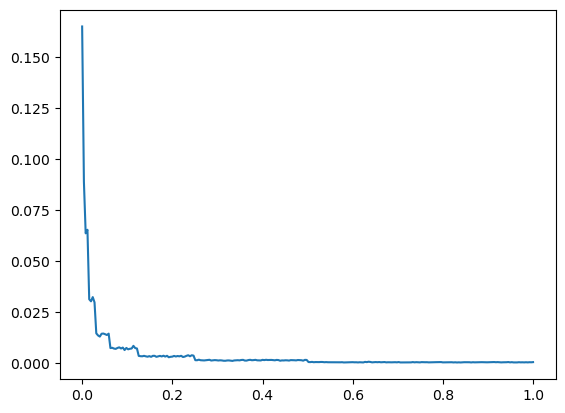

In [27]:
plt.plot(x,(dist))

In [55]:
dist2[256//3-2:256//3+3]

tensor([0.0232, 0.0499, 0.0878, 0.0370, 0.0301])

In [54]:
dist2[256//3*2-2:256//3*2+3]

tensor([0.0296, 0.0342, 0.0862, 0.0458, 0.0206])

In [52]:
dist2[256//3*2-1]

tensor(0.0342)

In [53]:
dist2[256//3*2+1]

tensor(0.0458)

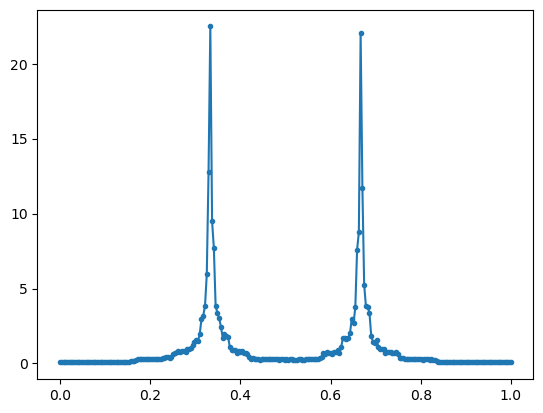

In [111]:
plt.plot(np.linspace(0,1,dist2.shape[0]),(dist2)*dist2.shape[0],'.-')
# plt.plot(np.linspace(0,1,dist3.shape[0]),(dist3)*dist3.shape[0],'-')
# plt.plot(np.linspace(0,1,dist4.shape[0]),(dist4)*dist4.shape[0],'-')
# plt.plot(np.linspace(0,1,dist5.shape[0]),(dist5)*dist5.shape[0],'-')
# plt.xlim([1/3-.005,1/3+.005])
# plt.yscale('log')

(0.3233333333333333, 0.3433333333333333)

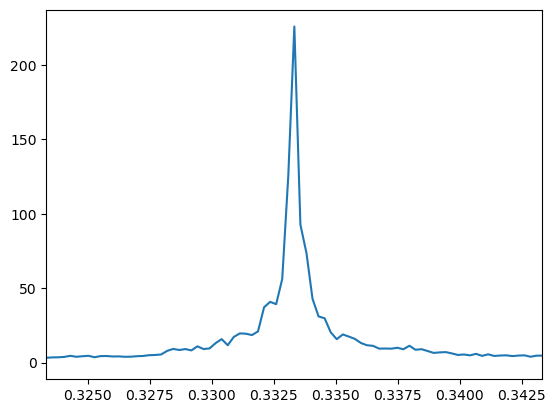

In [127]:
plt.plot(np.linspace(0,1,dist3.shape[0]),(dist3)*dist3.shape[0])
plt.xlim([1/3-.01,1/3+.01])

In [59]:
dist3[dist3.shape[0]//3]/dist3[dist3.shape[0]//3+1]

tensor(2.4384)

In [61]:
dist2[dist2.shape[0]//3]/dist2[dist2.shape[0]//3+1]

tensor(2.3711)

In [46]:
dist3[dist3.shape[0]//3]+dist3[dist3.shape[0]//3*2]

tensor(0.1021)

In [47]:
dist2[dist2.shape[0]//3]+dist2[dist2.shape[0]//3*2]

tensor(0.1740)

In [40]:
0b101010101010

2730

In [41]:
0b010101010101

1365

In [43]:
4096//3*2

2730

In [44]:
def generate_bitstring(n):
    l=np.arange(1<<n)
    bin_list=[bin(i)[2:].zfill(n) for i in l]
    bin_list=[[int(b) for b in i] for i in bin_list]

    return np.array(bin_list)

In [135]:
bitstring=generate_bitstring(12)

In [47]:
def ZZ(bitstring,k=2):
    n=bitstring.shape[1]
    J=k**np.arange(n-2,-1,-1)
    return np.sum(J*(2*bitstring[:,:-1]-1)*(2*bitstring[:,1:]-1),axis=1)

In [48]:
def Z(bitstring,k=2):
    n=bitstring.shape[1]
    J=k**np.arange(n-1,-1,-1)
    return np.sum(J*(2*bitstring-1),axis=1)

In [118]:
def Z_domain(bitstring,k=2):
    dw_pos=[]
    for bs in bitstring:
        pos=0
        while pos<bs.shape[0] and bs[pos]==0:
            pos+=1
        dw_pos.append(bs.shape[0]-pos)

    return np.array(dw_pos)

In [132]:
def ZZ_domain(bitstring,k=2):
    dw=(2*bitstring[:,:-1]-1)*(2*bitstring[:,1:]-1)
    dw_pos=[]
    for bs in dw:
        pos=0
        while pos<bs.shape[0] and bs[pos]==-1:
            pos+=1
        dw_pos.append(bs.shape[0]-pos)

    return np.array(dw_pos)

In [144]:
en=Z_domain(bitstring)

In [136]:
en=ZZ_domain(bitstring)

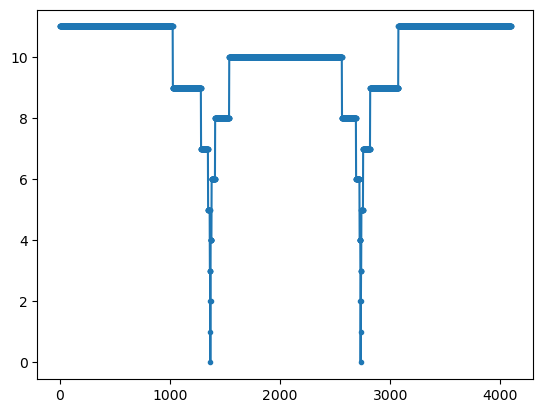

In [137]:
plt.plot(en,'.-')

In [113]:
bitstring

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [120]:
en

array([ 0,  1,  2, ..., 12, 12, 12])

In [62]:
en=ZZ(bitstring)

In [143]:
en=Z(bitstring)

In [103]:
dist2[170]

tensor(0.0862)

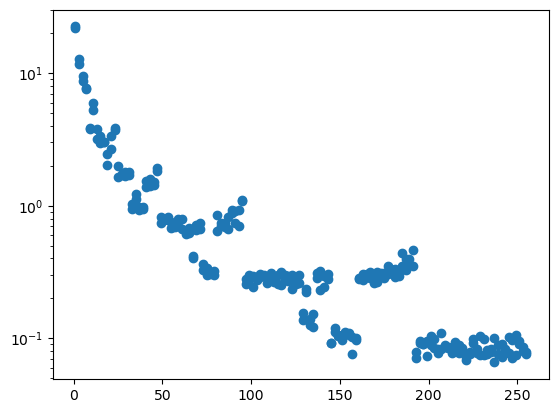

In [59]:
plt.scatter(en-en.min()+1,(wfs_1_3_8_dist[10,0])*wfs_1_3_8_dist[10,0].shape[0])
plt.yscale('log')
# plt.xscale('log')

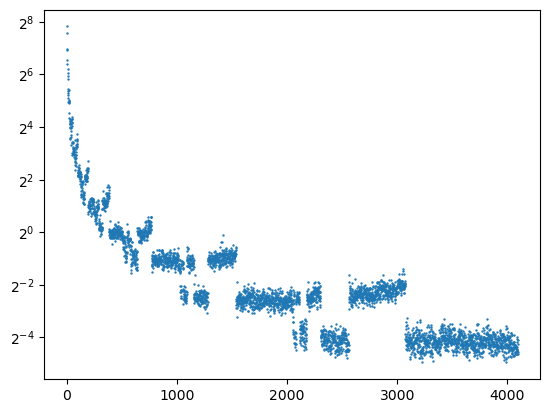

In [68]:
plt.scatter(en-en.min()+1,(wfs_1_3_12_dist[10,0])*wfs_1_3_12_dist[10,0].shape[0],s=0.5)
plt.yscale('log',base=2)
# plt.xscale('log')

In [161]:
import pandas as pd

In [176]:
df=pd.DataFrame({'en':en,'p':wfs_0_12_dist[10,0]*wfs_0_12_dist[10,0].shape[0]})
df_half=pd.DataFrame({'en':en,'p':wfs_0_12_dist_half[10,0]*wfs_0_12_dist_half[10,0].shape[0]})
df_quarter=pd.DataFrame({'en':en,'p':wfs_0_12_dist_quarter[10,0]*wfs_0_12_dist_quarter[10,0].shape[0]})

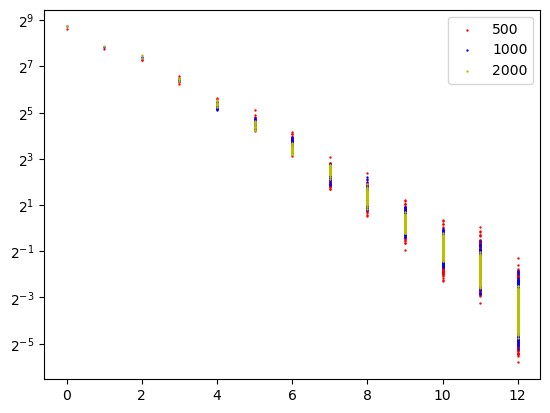

In [159]:
plt.scatter(en,(wfs_0_12_dist_quarter[10,0])*wfs_0_12_dist_quarter[10,0].shape[0],s=0.5,label='500',color='r')
plt.scatter(en,(wfs_0_12_dist_half[10,0])*wfs_0_12_dist_half[10,0].shape[0],s=0.5,label='1000',color='b')
plt.scatter(en,(wfs_0_12_dist[10,0])*wfs_0_12_dist[10,0].shape[0],s=0.5,label='2000',color='y')

plt.yscale('log',base=2)
# plt.xscale('log')
plt.legend()

,p
en,
0,422.283752
1,234.312225
2,172.685638
3,86.959503
4,41.756622
5,21.515642
6,10.576066
7,5.557803
8,2.533135


In [ ]:
plt.plot(df.groupby('en').mean())

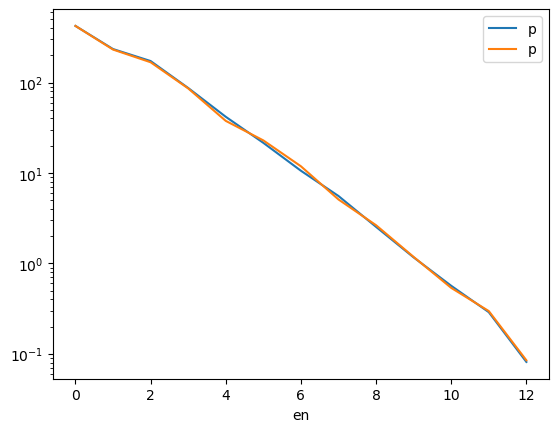

In [183]:
fig,ax=plt.subplots()
df.groupby('en').mean().plot(ax=ax,label='2000')
df_half.groupby('en').mean().plot(ax=ax,label='1000')

ax.legend()
ax.set_yscale('log')

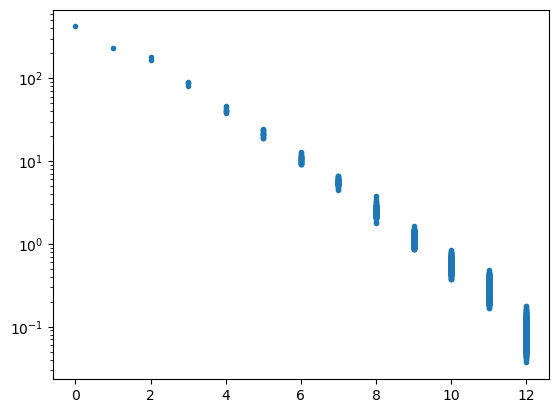

In [166]:
plt.plot(df['en'],df['p'],'.')
plt.yscale('log')

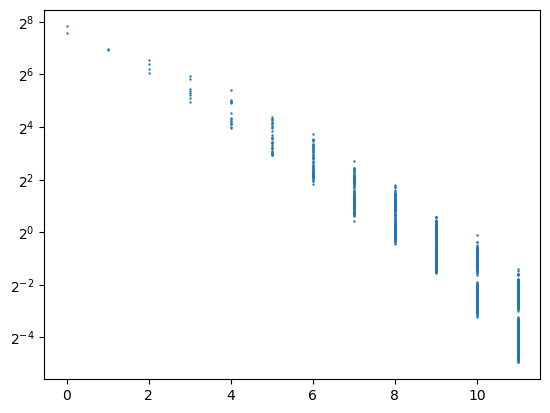

In [138]:
plt.scatter(en,(wfs_1_3_12_dist[10,0])*wfs_1_3_12_dist[10,0].shape[0],s=0.5)
plt.yscale('log',base=2)
# plt.xscale('log')

In [200]:
en=Z(bitstring,k=2)

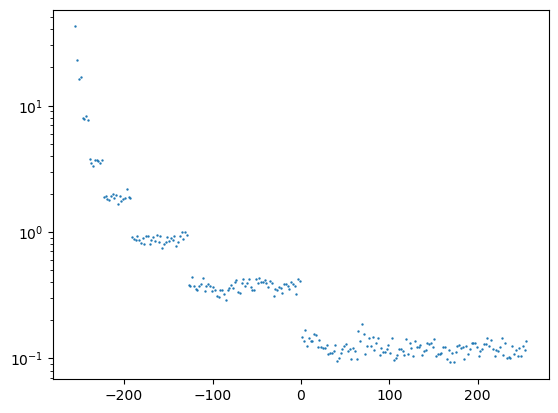

In [203]:
plt.scatter(en,(dist)*dist.shape[0],s=0.5)
plt.yscale('log')
# plt.xscale('log')

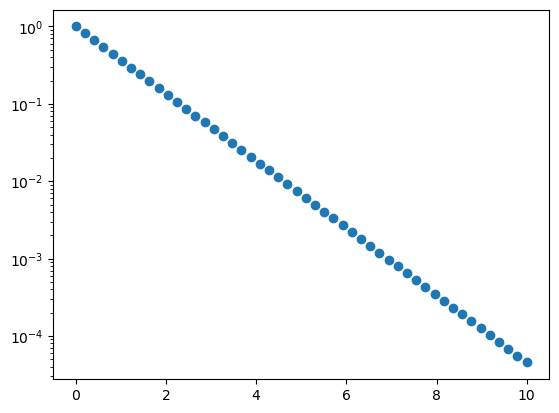

In [204]:
plt.scatter(np.linspace(0, 10),np.exp(-np.linspace(0, 10)**1))
plt.yscale(value='log')

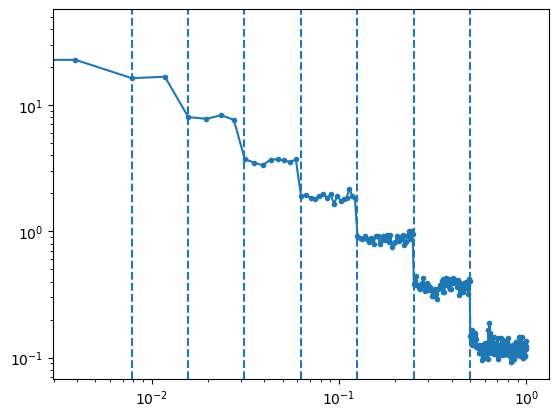

In [140]:
plt.plot(np.linspace(0,1,dist.shape[0]),(dist)*dist.shape[0],'.-')
plt.yscale('log')
plt.xscale('log')
for i in np.arange(1,8):
    plt.axvline(x=1/2**i,ls='dashed')

In [179]:
np.log2(wfs_0_12_dist.shape[-1])

12.0

# Distribution of xj=0

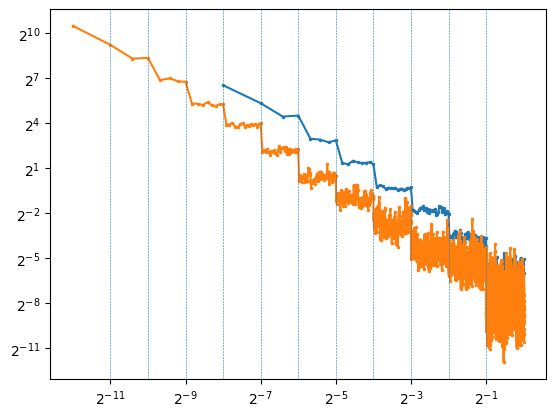

In [ ]:
fig,ax=plt.subplots()

ax.plot(np.arange(0,1,1/wfs_0_8_dist[12,0].shape[0])+1/wfs_0_8_dist[12,0].shape[0],(wfs_0_8_dist[12,0])*wfs_0_8_dist[12,0].shape[0],'.-',markersize=3,label='L=8')

ax.plot(np.arange(0,1,1/wfs_0_10_dist[12,0].shape[0])+1/wfs_0_10_dist[12,0].shape[0],(wfs_0_10_dist[12,0])*wfs_0_10_dist[12,0].shape[0],'.-',markersize=3,label='L=8')

ax.plot(np.arange(0,1,1/wfs_0_12_dist[12,0].shape[0])+1/wfs_0_12_dist[12,0].shape[0],(wfs_0_12_dist[12,0])*wfs_0_12_dist[12,0].shape[0],'.-',markersize=3,label='L=12')

ax.set_yscale('log',base=2)
ax.set_xscale('log',base=2)
# ax.grid('on',axis='y')

for i in np.arange(1,12):
    ax.axvline(x=1/2**i,ls='dashed',lw=0.4,)

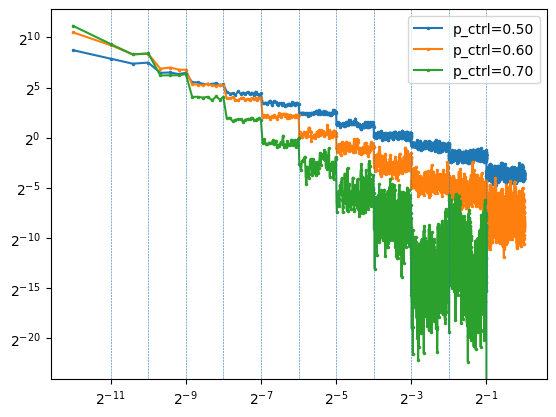

In [74]:
fig,ax=plt.subplots()
p_list=np.linspace(0,1,21)
for i in [10,12,14]:
    ax.plot(np.arange(0,1,1/wfs_0_12_dist[i,0].shape[0])+1/wfs_0_12_dist[i,0].shape[0],(wfs_0_12_dist[i,0])*wfs_0_12_dist[i,0].shape[0],'.-',markersize=3,label=f'p_ctrl={p_list[i]:.2f}')

ax.legend()
ax.set_yscale('log',base=2)
ax.set_xscale('log',base=2)
# ax.grid('on',axis='y')

for i in np.arange(1,12):
    ax.axvline(x=1/2**i,ls='dashed',lw=0.4,)

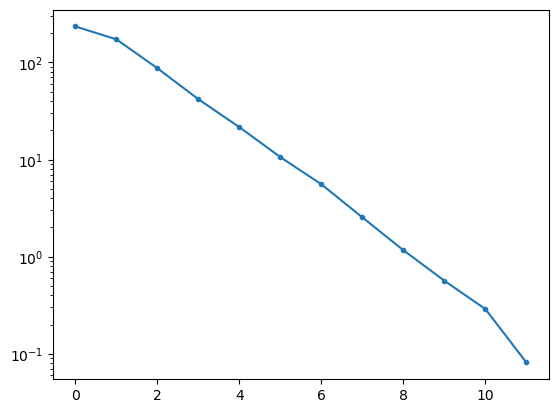

In [82]:
plt.plot([torch.mean(wfs_0_12_dist[10,0][2**i:2**(i+1)])*wfs_0_12_dist[10,0].shape[0] for i in range(12)],'.-')
plt.yscale('log')

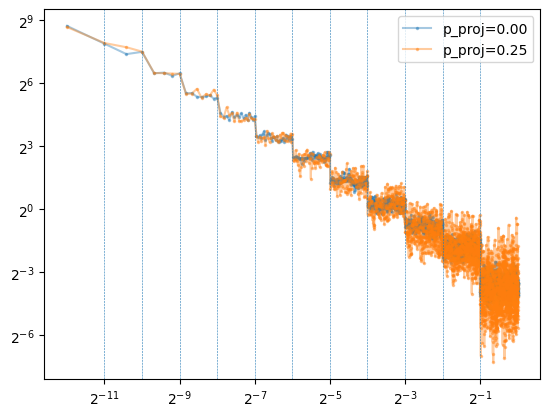

In [26]:
fig,ax=plt.subplots()
p_list=np.linspace(0,1,21)
for i in [0,5,]:
    ax.plot(np.arange(0,1,1/wfs_0_12_dist[10,i].shape[0])+1/wfs_0_12_dist[10,i].shape[0],(wfs_0_12_dist[10,i])*wfs_0_12_dist[10,i].shape[0],'.-',markersize=3,label=f'p_proj={p_list[i]:.2f}',alpha=0.4)

ax.legend()
ax.set_yscale('log',base=2)
ax.set_xscale('log',base=2)
# ax.grid('on',axis='y')

for i in np.arange(1,12):
    ax.axvline(x=1/2**i,ls='dashed',lw=0.4,)

# Distribution of xj={1/3,2/3}

In [27]:
wfs_1_3_8_dist[10,0].shape[0]

256

In [41]:
def generate_distance_1_3(wf):
    bitstring_1_3=np.arange(0,1,1/wf.shape[0])
    bitstring_1_3_distance=np.abs(np.r_[bitstring_1_3[:bitstring_1_3.shape[0]//2]-bitstring_1_3[bitstring_1_3.shape[0]//3],bitstring_1_3[bitstring_1_3.shape[0]//2:]-bitstring_1_3[bitstring_1_3.shape[0]//3*2]])
    return bitstring_1_3_distance

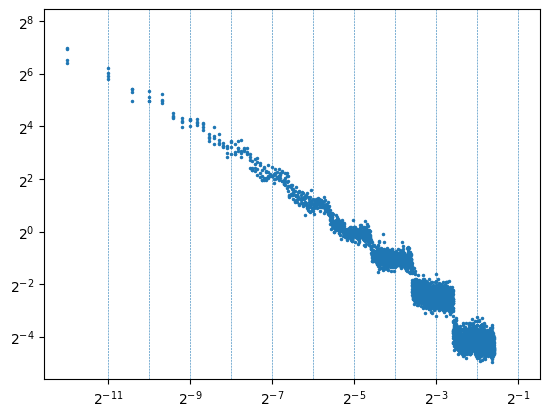

In [98]:
fig,ax=plt.subplots()
# ax.plot(generate_distance_1_3(wfs_1_3_8_dist[10,0]),(wfs_1_3_8_dist[10,0])*wfs_1_3_8_dist[10,0].shape[0],'.',markersize=3,label='L=8')
ax.plot(generate_distance_1_3(wfs_1_3_12_dist[10,0]),(wfs_1_3_12_dist[10,0])*wfs_1_3_12_dist[10,0].shape[0],'.',markersize=3,label='L=12')
# ax.plot(np.linspace(0,1,wfs_1_3_12_dist[12,0].shape[0])+1/wfs_1_3_12_dist[12,0].shape[0],(wfs_1_3_12_dist[12,0])*wfs_1_3_12_dist[12,0].shape[0],'.-',markersize=3,label='L=12')


ax.set_yscale('log',base=2)
ax.set_xscale('log',base=2)
# ax.grid('on',axis='y')

for i in np.arange(1,12):
    ax.axvline(x=1/2**i,ls='dashed',lw=0.4,)

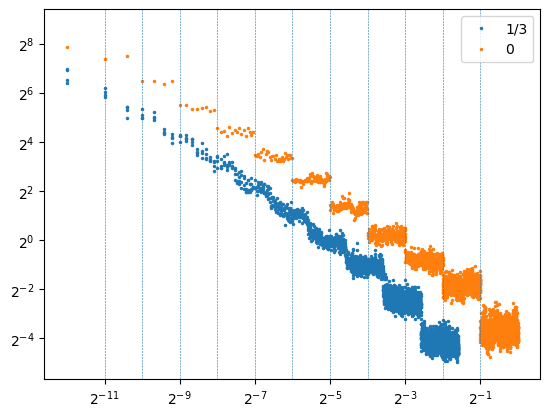

In [104]:
fig,ax=plt.subplots()
ax.plot(generate_distance_1_3(wfs_1_3_12_dist[10,0]),(wfs_1_3_12_dist[10,0])*wfs_1_3_12_dist[10,0].shape[0],'.',markersize=3,label='1/3')

ax.plot(np.arange(0,1,1/wfs_0_12_dist[10,0].shape[0]),(wfs_0_12_dist[10,0])*wfs_0_12_dist[10,0].shape[0],'.',markersize=3,label='0')



ax.set_yscale('log',base=2)
ax.set_xscale('log',base=2)
# ax.grid('on',axis='y')
ax.legend()

for i in np.arange(1,12):
    ax.axvline(x=1/2**i,ls='dashed',lw=0.4,)

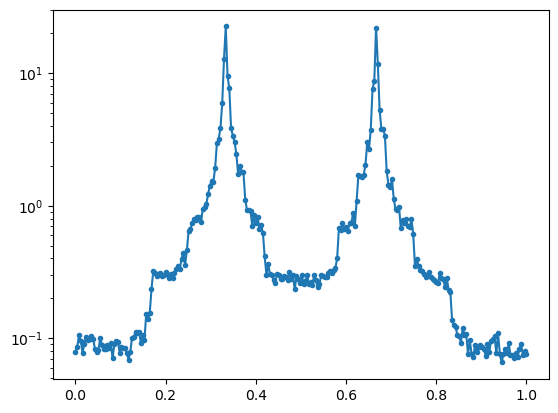

In [135]:
plt.plot(np.linspace(0,1,dist2.shape[0]),(dist2)*dist2.shape[0],'.-')
plt.yscale('log')

In [57]:
str(2<<1)

'4'

In [ ]:
check correlation , FWHM, fit lorentzian
peak,FWHM as a function of (p_ctrl, p_proj,)
what curve is best fit? Does not look like Lorenzian because it seems unbounded at the center, well could be just gaussian, where the sigma is infinitely small? lorentzian is also possible though. because both distributions have 1/lw at the center 
is there any hamiltonian describe this?

can we have a Heisenberg model where the J is like 2^n?

# Load data

In [11]:
import h5py
import numpy as np

In [12]:
import matplotlib.pyplot as plt

In [13]:
L_list=np.arange(8,18,2)

In [14]:
f_1_3={}
for L in L_list:
    f_1_3[L]=h5py.File(f'CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(1-3,2-3)_seed0_64_wf.hdf5')

In [15]:
f_0={}
for L in L_list:
    f_0[L]=h5py.File(f'CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed0_64_wf.hdf5')

In [16]:
p_ctrl_list=np.linspace(0,1,21)

In [17]:
def convert_to_re_im(data):
    return np.concatenate([(data).real,(data).real],axis=-1)
def convert_to_abs(data):
    return np.abs(data)**2


In [215]:
from scipy.stats import norm

(-0.4, 0.4)

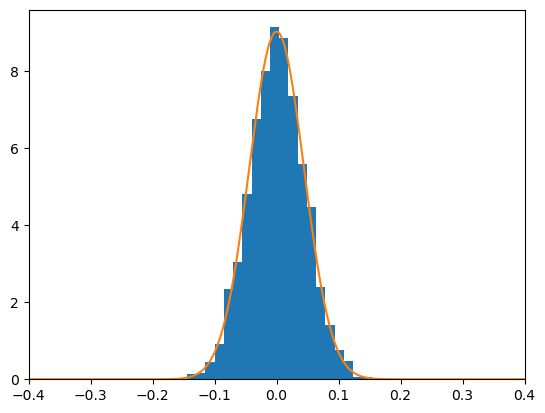

In [216]:
x=np.linspace(-1,1,1000)


plt.hist(convert_to_re_im(f_1_3[8]['wf_8'][0,0,0][(1,0)*4][:,0]),density=True,bins=20)
plt.plot(x,norm.pdf(x,scale=1/2**4.5))
plt.xlim(-.4,.4)

In [93]:
def update(i):
    # plt.hist(convert_to_re_im(f['wf_8'][-1,0,i][(1,0)*4][:,0]),density=True,bins=20)
    # plt.plot(x,norm.pdf(x,scale=1/2**4.5))

    plt.hist(convert_to_abs(f['wf_8'][-2,0,i][(1,0)*4][:,0])+convert_to_abs(f['wf_8'][-2,0,i][(0,1)*4][:,0]),density=True,bins=20)
    # plt.plot(x/2**9,chi2.pdf(x,df=2)*2**9)

    # plt.xlim(-1,1)
    # plt.xlim(0,1.2)

In [52]:
import ipywidgets as widgets
from IPython.display import display

In [82]:
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=2*8**2-1,
    step=1,
    description='i:',
    continuous_update=False
)

In [94]:
widgets.interactive(update, i=slider)


interactive(children=(IntSlider(value=11, continuous_update=False, description='i:', max=127), Output()), _dom…

In [13]:
f['wf_8'][0,0,0][(0,)*8][:,0]

array([ 0.05673277+0.02076928j, -0.0342991 -0.07059319j,
       -0.08387879-0.05316761j, ...,  0.01847361+0.03742136j,
        0.08014921+0.01264936j,  0.01647888-0.04576589j])

In [16]:
from scipy.stats import chi2

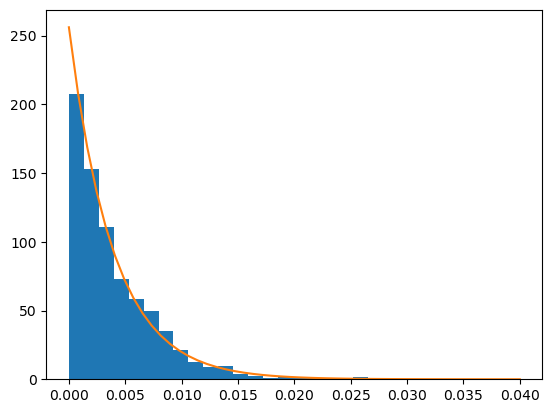

In [20]:
x=np.linspace(0,0.04*2**9)
plt.hist(convert_to_abs(f['wf_8'][0,0,-1][(1,0)*4][:,0]),density=True,bins=20)
plt.plot(x/2**9,chi2.pdf(x,df=2)*2**9)

In [7]:
from scipy.stats import gaussian_kde

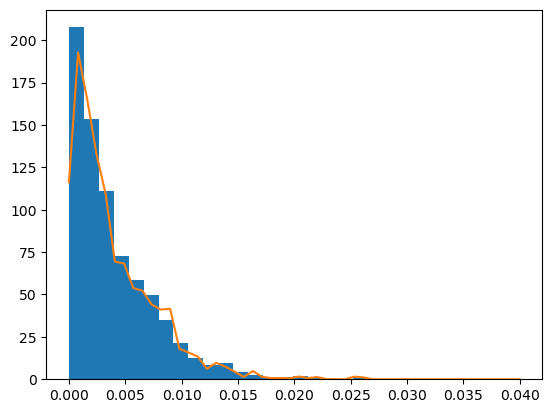

In [34]:
x=np.linspace(0,0.04*2**9)
kernel=gaussian_kde(convert_to_abs(f['wf_8'][0,0,-1][(1,0)*4][:,0]),bw_method=0.04,)
plt.hist(convert_to_abs(f['wf_8'][0,0,-1][(1,0)*4][:,0]),density=True,bins=20)

plt.plot(np.linspace(0,0.04),kernel(np.linspace(0,0.04)),)
# plt.plot(x/2**9,chi2.pdf(x,df=2)*2**9)

# Distribution along bitstring

In [267]:
import pandas as pd

In [328]:
p_bs_0={L:[convert_to_abs(f_0[L][f'wf_{L}'][(p_idx,0,-1)]).mean(axis=(-2,-1)).flatten() for p_idx in range(21)] for L in L_list}

In [329]:
L=16
df_0={p_ctrl_idx:pd.DataFrame({'p':p_bs_0[L][p_ctrl_idx]*2**L,'FDW':np.array(convert_bitstring_to_dw(L))})for p_ctrl_idx in range(21)}

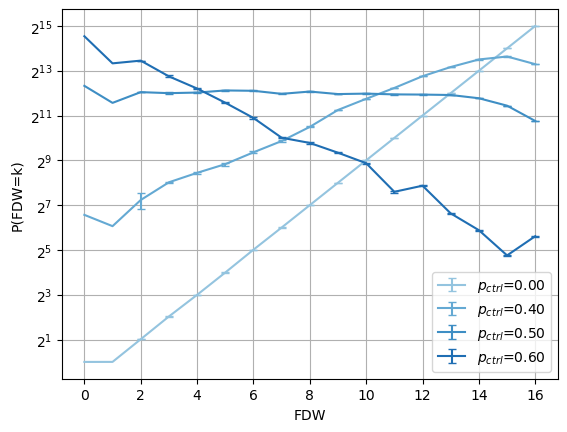

In [347]:
fig,ax=plt.subplots()
color_list=[plt.cm.Blues(0.4+0.6*(i/len(L_list))) for i in range(4)]
for p_ctrl_idx,color in zip([0,8,10,12,],color_list):
    error=df_0[p_ctrl_idx].groupby('FDW').sem()*df_0[p_ctrl_idx].groupby('FDW').count()
    pd.concat([df_0[p_ctrl_idx].groupby('FDW').sum(),error],axis=1).set_axis(['p','perr'],axis=1).plot(ax=ax,y='p',label=f'$p_{{ctrl}}$={p_ctrl_list[p_ctrl_idx]:.2f}',yerr='perr',capsize=3,color=color)

ax.set_yscale('log',base=2)
ax.set_xlabel('FDW')
ax.set_ylabel('P(FDW=k)')
ax.legend()
ax.grid('on',)

In [331]:
p_bs_1_3={L:[convert_to_abs(f_1_3[L][f'wf_{L}'][(p_idx,0,-1)]).mean(axis=(-2,-1)).flatten() for p_idx in range(21)] for L in L_list}

In [340]:
L=16
df_1_3={p_ctrl_idx:pd.DataFrame({'p':p_bs_1_3[L][p_ctrl_idx]*2**L,'FDW':np.array(convert_bitstring_to_dw(L,ZZ=True))})for p_ctrl_idx in range(21)}

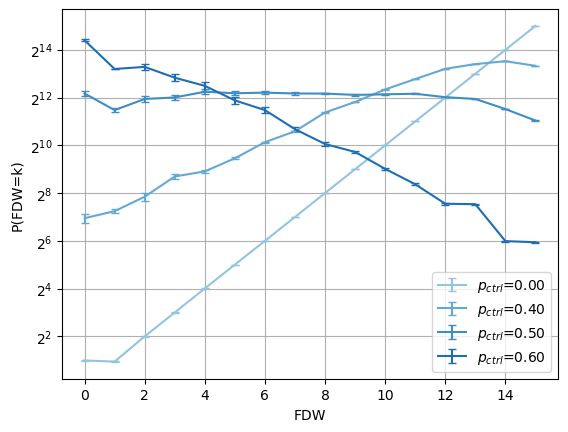

In [348]:
fig,ax=plt.subplots()
color_list=[plt.cm.Blues(0.4+0.6*(i/len(L_list))) for i in range(4)]
for p_ctrl_idx,color in zip([0,8,10,12,],color_list):
    error=df_1_3[p_ctrl_idx].groupby('FDW').sem()*df_1_3[p_ctrl_idx].groupby('FDW').count()
    pd.concat([df_1_3[p_ctrl_idx].groupby('FDW').sum(),error],axis=1).set_axis(['p','perr'],axis=1).plot(ax=ax,y='p',label=f'$p_{{ctrl}}$={p_ctrl_list[p_ctrl_idx]:.2f}',yerr='perr',capsize=3,color=color)

ax.set_yscale('log',base=2)
ax.set_xlabel('FDW')
ax.set_ylabel('P(FDW=k)')
ax.legend()
ax.grid('on',)

# Distribution along overlap

In [354]:
convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)+(0,1)*(L//2)]).shape

(2000, 1)

In [18]:
from scipy.stats import chi2,norm

### xj

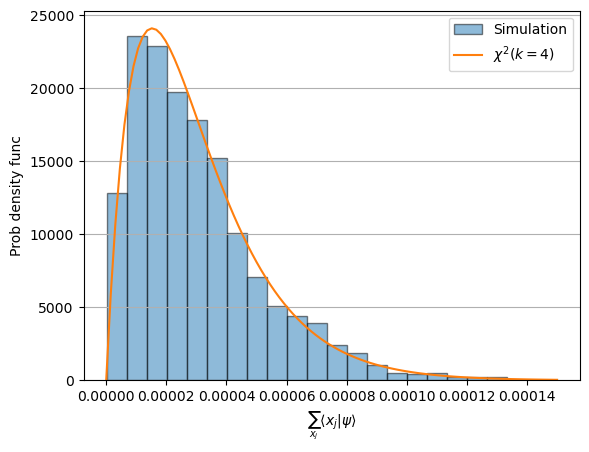

In [401]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)+(0,1)*(L//2)])+convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)+(1,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

x=np.linspace(0,0.00015*2**(L+1),100)
ax.plot(x/2**(L+1),chi2.pdf(x,df=4)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

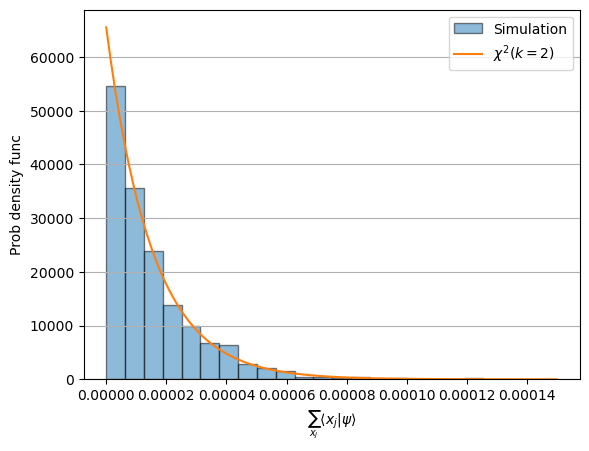

In [406]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_0[L][f'wf_{L}'][(0,0,-1)+(0,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

x=np.linspace(0,0.00015*2**(L+1),100)
ax.plot(x/2**(L+1),chi2.pdf(x,df=2)*2**(L+1),label='$\chi^2(k=2)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

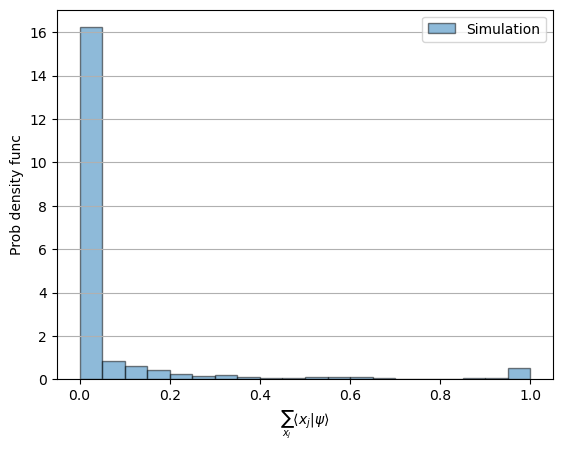

In [403]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_1_3[L][f'wf_{L}'][(10,0,-1)+(0,1)*(L//2)])+convert_to_abs(f_1_3[L][f'wf_{L}'][(10,0,-1)+(1,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=4)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

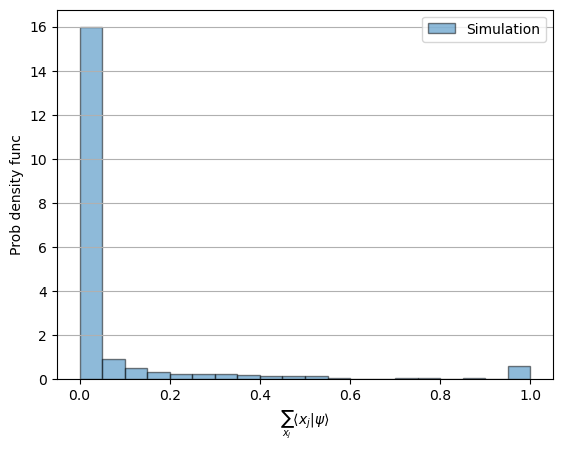

In [405]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_0[L][f'wf_{L}'][(10,0,-1)+(0,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=2)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

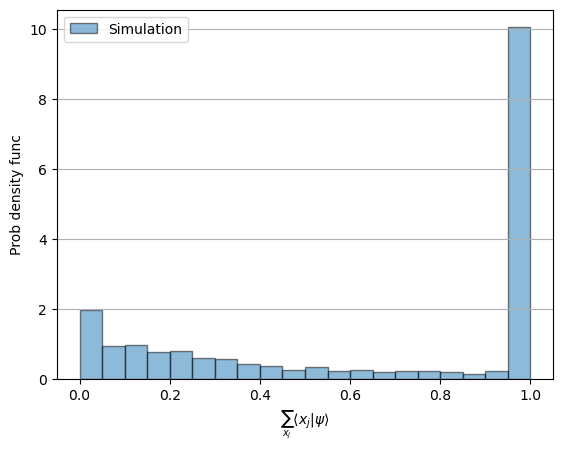

In [407]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_1_3[L][f'wf_{L}'][(15,0,-1)+(0,1)*(L//2)])+convert_to_abs(f_1_3[L][f'wf_{L}'][(15,0,-1)+(1,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=4)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

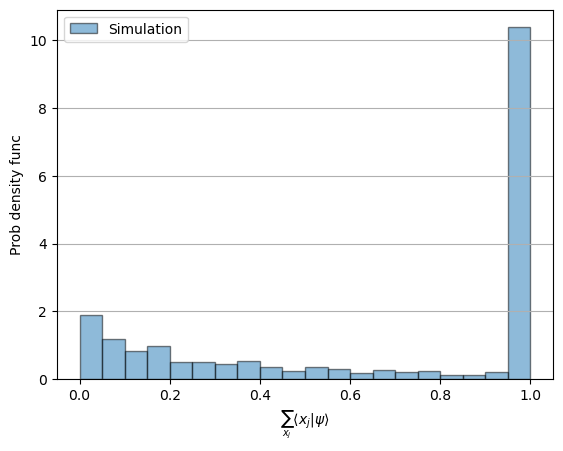

In [408]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_0[L][f'wf_{L}'][(15,0,-1)+(0,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=2)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

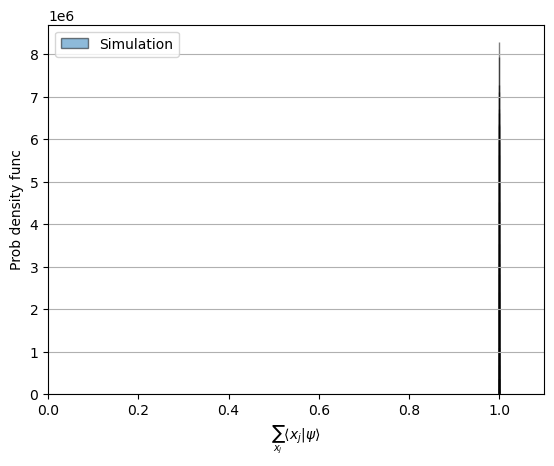

In [413]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_1_3[L][f'wf_{L}'][(20,0,-1)+(0,1)*(L//2)])+convert_to_abs(f_1_3[L][f'wf_{L}'][(20,0,-1)+(1,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=4)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.set_xlim(0,1.1)

ax.grid('on',axis='y')

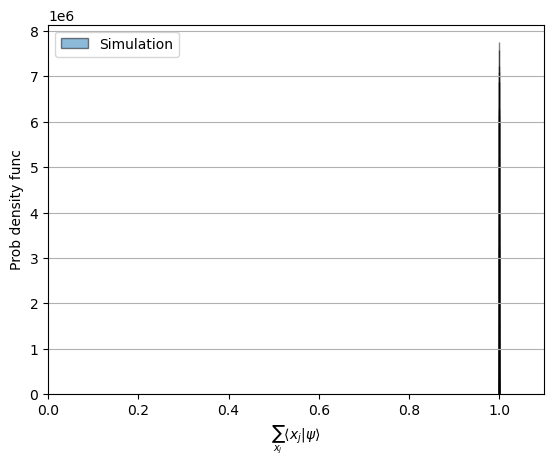

In [412]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_0[L][f'wf_{L}'][(20,0,-1)+(0,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=2)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.set_xlim(0,1.1)
ax.grid('on',axis='y')

### non xj

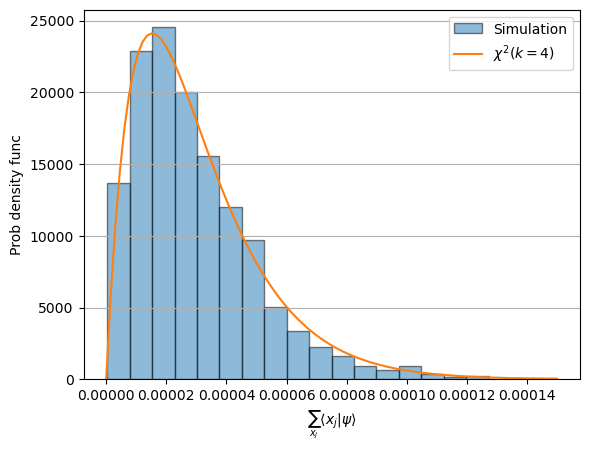

In [20]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)+(0,1)*(L//2-1)+(0,0)])+convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)+(1,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

x=np.linspace(0,0.00015*2**(L+1),100)
ax.plot(x/2**(L+1),chi2.pdf(x,df=4)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

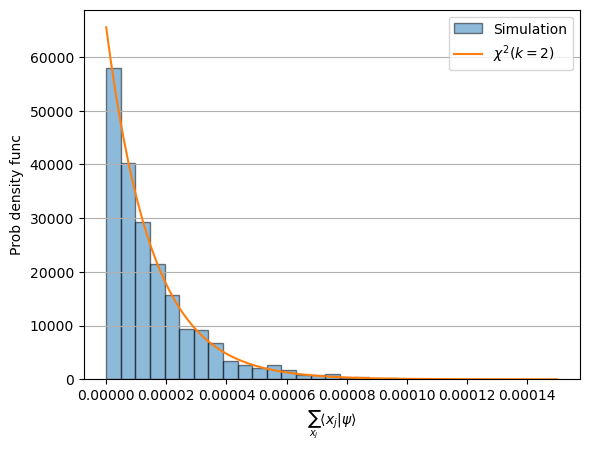

In [21]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_0[L][f'wf_{L}'][(0,0,-1)+(0,0)*(L//2-1)+(0,1)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

x=np.linspace(0,0.00015*2**(L+1),100)
ax.plot(x/2**(L+1),chi2.pdf(x,df=2)*2**(L+1),label='$\chi^2(k=2)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

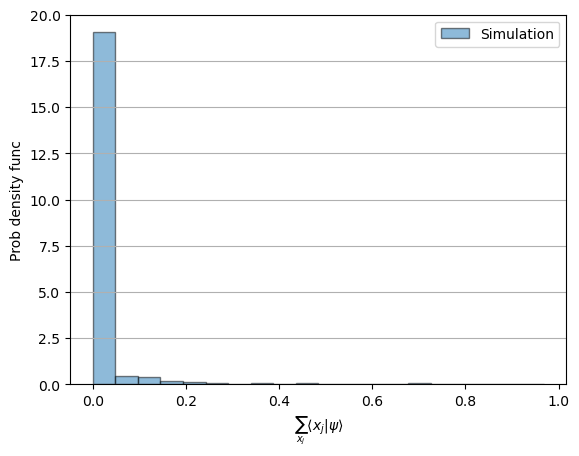

In [23]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_1_3[L][f'wf_{L}'][(10,0,-1)+(0,1)*(L//2-1)+(0,0)])+convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)+(1,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=4)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

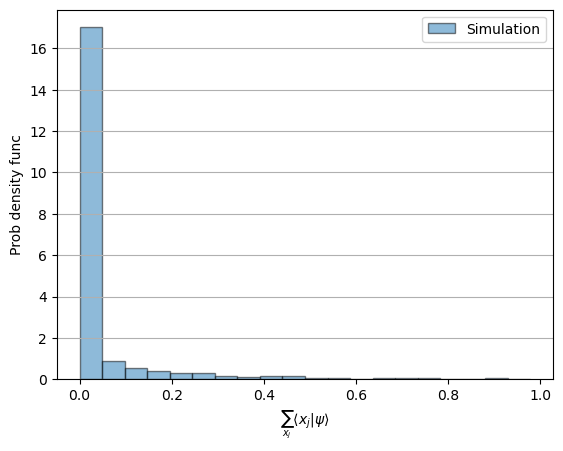

In [28]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_0[L][f'wf_{L}'][(10,0,-1)+(0,0)*(L//2-1)+(0,1)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=2)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

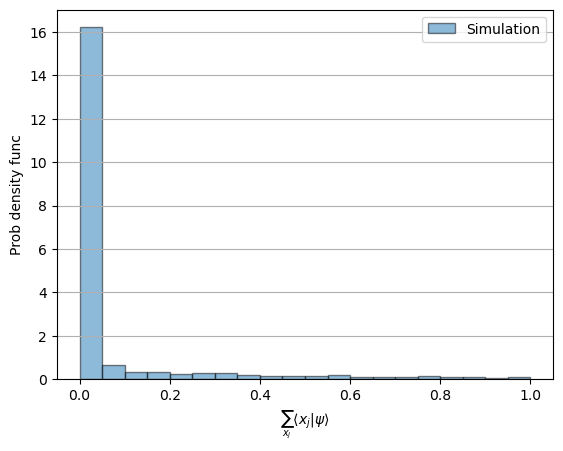

In [24]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_1_3[L][f'wf_{L}'][(15,0,-1)+(0,1)*(L//2-1)+(0,0)])+convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)+(1,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=4)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

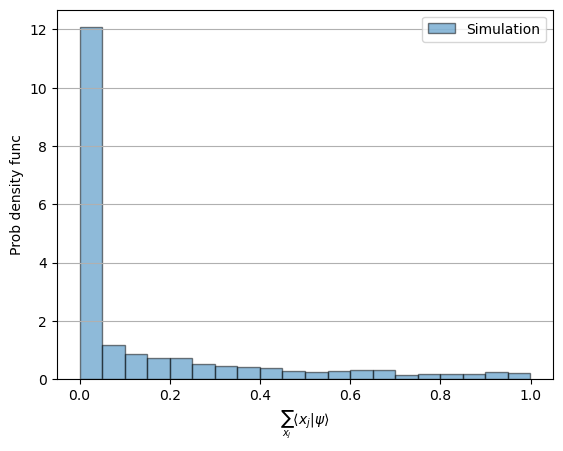

In [29]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_0[L][f'wf_{L}'][(15,0,-1)+(0,0)*(L//2-1)+(0,1)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=2)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.grid('on',axis='y')

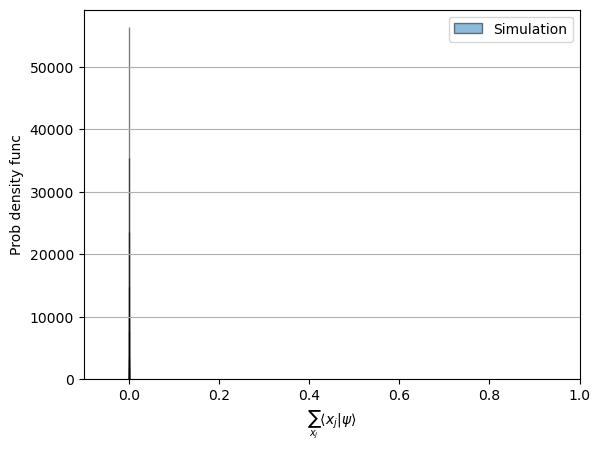

In [44]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_1_3[L][f'wf_{L}'][(20,0,-1)+(0,1)*(L//2-1)+(0,0)])+convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)+(1,0)*(L//2)]),bins=20,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=4)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.set_xlim(-0.1,1.)

ax.grid('on',axis='y')

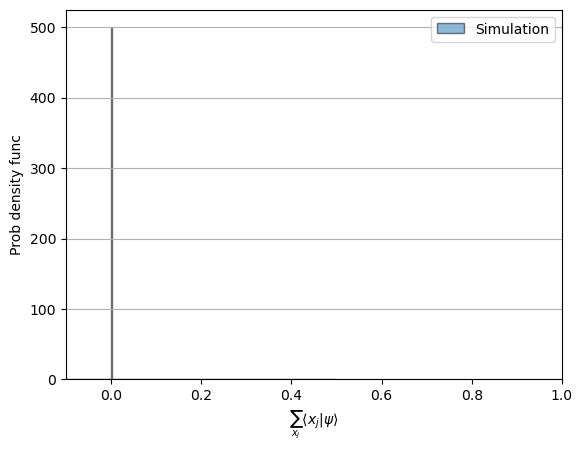

In [50]:
fig,ax=plt.subplots()
L=16
ax.hist(convert_to_abs(f_0[L][f'wf_{L}'][(20,0,-1)+(0,0)*(L//2-1)+(0,1)]),bins=500,density=True,edgecolor='k',alpha=0.5,label='Simulation')

# x=np.linspace(0,0.00015*2**(L+1),100)
# ax.plot(x/2**(L+1),chi2.pdf(x,df=2)*2**(L+1),label='$\chi^2(k=4)$')

ax.set_xlabel(r'$\sum_{x_j}\langle x_j | \psi \rangle$')
ax.set_ylabel('Prob density func')

ax.legend()
ax.set_xlim(-0.1,1.)

ax.grid('on',axis='y')

In [421]:
def binder(O):
    O_mean=np.mean(O,axis=-1)[:,np.newaxis]
    # return np.mean((O-O_mean)**4,axis=-1)/(np.mean((O-O_mean)**2,axis=-1)**2)
    return 1-np.mean((O-O_mean)**4,axis=-1)/(3*np.mean((O-O_mean)**2,axis=-1)**2)

In [351]:
def binder_logsum(O):
    O_mean=np.mean(O,axis=-1)[:,np.newaxis]
    O_c2=np.log(np.abs(O-O_mean))*2
    O_c4=np.log(np.abs(O-O_mean))*4
    n=np.log(O.shape[-1])
    return np.exp((scipy.special.logsumexp(O_c4,axis=-1)-n)-(scipy.special.logsumexp(O_c2,axis=-1)-n)*2)
    return 1-np.exp((scipy.special.logsumexp(O_c4,axis=-1)-n)-(scipy.special.logsumexp(O_c2,axis=-1)-n)*2)/3

In [430]:
wf=torch.stack(wfs_0_8)
wf.shape

torch.Size([441, 2, 2, 2, 2, 2, 2, 2, 2, 2000, 1])

In [427]:
wf=torch.stack(wfs_0_8)
wf=wf.reshape((21,21,-1,wf.shape[-2],1))
wf_re=(wf).real
wf_im=(wf).imag
wf_haar=torch.cat([wf_re,wf_im],axis=-2)

In [343]:
wf_haar.shape

torch.Size([21, 21, 256, 4000, 1])

In [316]:
wf=torch.stack(wfs_0_12)
wf=wf.reshape((21,21,-1,wf.shape[-2],1))
wf_re=(wf).real
wf_im=(wf).imag
wf_haar_12=torch.cat([wf_re,wf_im],axis=-2)

In [468]:
from scipy.stats import norm
x=np.linspace(-1,1,1000)
# y=expon.pdf(x,)

In [301]:
O_map=np.array(wf_haar[:,0,0,:,0])

In [330]:
binder(O_map)

array([ 2.9996386,  3.5130796,  3.5590518, 10.921391 ,  6.5315924,
       11.116603 , 26.795805 , 24.441217 , 16.046837 , 10.164415 ,
        5.9971333,  4.3123927,  3.2750401,  2.673859 ,  2.3162212,
        2.0614083,  1.9220953,  1.7898794,  1.6570964,  1.5769017,
        1.5014787], dtype=float32)

Text(0, 0.5, '$\\overline{\\langle O \\rangle}$')

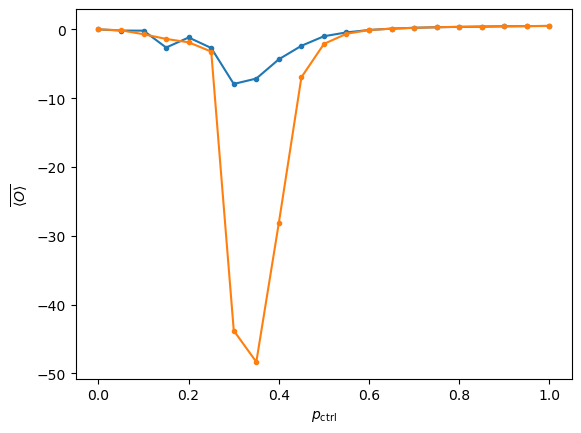

In [424]:
plt.plot(np.linspace(0,1,21),binder(np.array(wf_haar[:,0,0,:,0])),'.-')
plt.plot(np.linspace(0,1,21),binder(np.array(wf_haar_12[:,0,0,:,0])),'.-')
plt.xlabel(r'$p_{\rm ctrl}$')
plt.ylabel(r'$\overline{\langle O \rangle}$')
# plt.ylim([0,5])

In [399]:
(torch.abs(ensemble-1)<1e-1).sum()

tensor(292)

In [409]:
wf_haar[x,0,:].shape

torch.Size([1000, 256, 4000, 1])

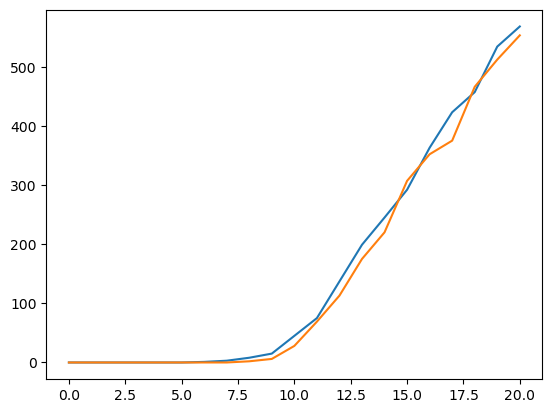

In [413]:
plt.plot([(torch.abs((wf_haar[(x,0,0)][:,0]-1))<1e-1).sum()  for x in range(21)])
plt.plot([(torch.abs((wf_haar_12[(x,0,0)][:,0]-1))<1e-1).sum()  for x in range(21)])

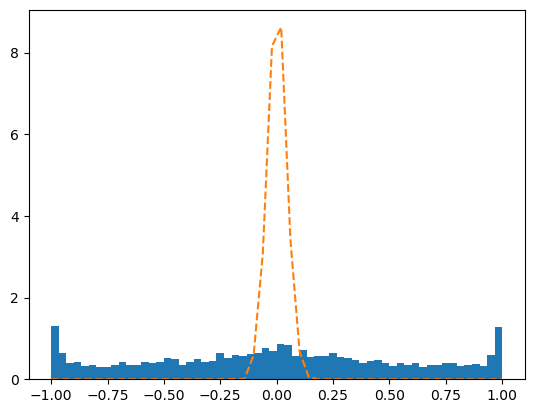

In [397]:
ensemble=wf_haar[(15,0,0)][:,0]
plt.hist(ensemble,bins=60,density=True)
# plt.plot(x,norm.pdf(x,scale=1/2**4.5))
plt.plot(x_kde,y_kde,ls='dashed')

In [8]:
from scipy.stats import gaussian_kde

In [377]:
kernel = gaussian_kde(ensemble,bw_method=0.05)

In [378]:
x_kde=np.linspace(-1,1)
y_kde = kernel(x_kde)


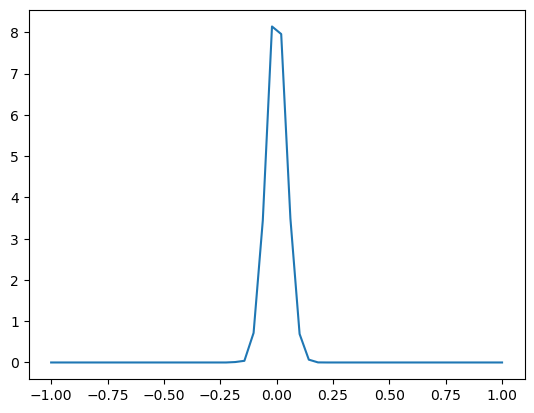

In [190]:
wf=torch.stack(wfs_0_8)
wf=wf.reshape((21,21,-1,wf.shape[-2],1))
wf_amp=torch.abs(wf)**2

In [418]:
wf=torch.stack(wfs_0_12)
wf=wf.reshape((21,21,-1,wf.shape[-2],1))
wf_amp_12=torch.abs(wf)**2

In [417]:
wf_amp[10,0,0,:,0].mean()

tensor(0.1648)

In [420]:
wf_amp_12[10,0,0,:,0].mean()

tensor(0.1031)

In [198]:
from scipy.stats import chi2
x = np.linspace(0, 20, 1000)
dof=2
y = chi2.pdf(x,dof)

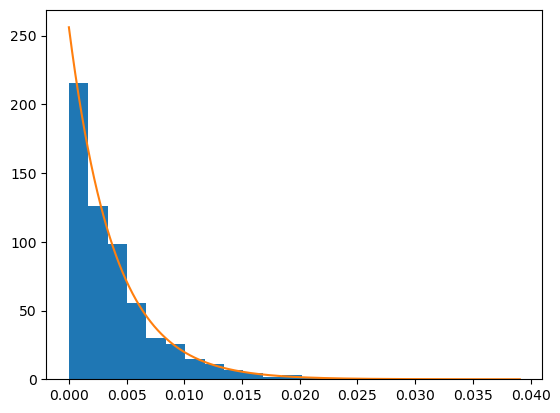

In [203]:
ensemble=wf_amp[(0,0,0)][:,0]
plt.hist(ensemble,bins=20,density=True)
plt.plot(x/2**9,y*2**9)

In [232]:
from scipy.stats import expon
x=np.linspace(0,1)
# y=expon.pdf(x,)

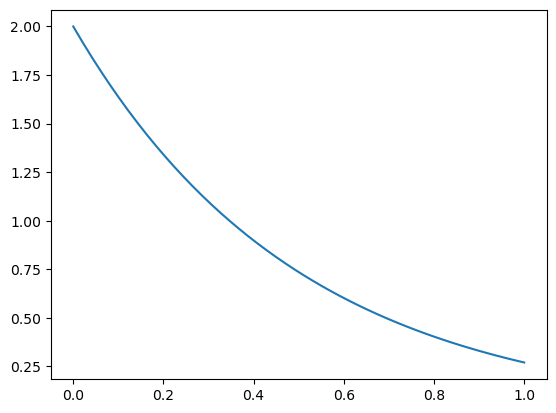

In [236]:
plt.plot(x,expon.pdf(x,scale=1/2))

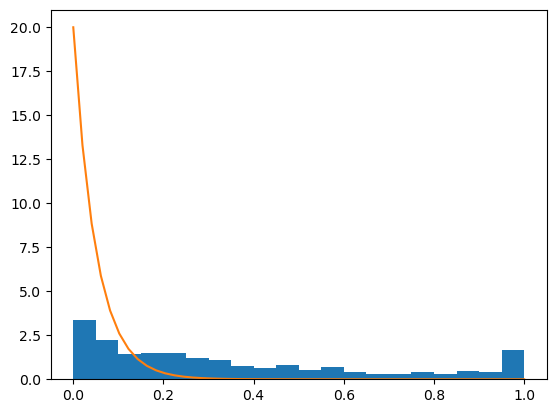

In [257]:
ensemble=wf_amp[15,0,0][:,0]
plt.hist(ensemble[ensemble<1],bins=20,density=True)
# plt.hist(ensemble/ensemble.mean()*dof,bins=20,density=True)
# plt.hist(wf_amp[10,0,3][:,0],bins=20,density=True,alpha=0.3,label='1')
# plt.hist(wf_amp[10,0,0][:,0],bins=20,density=True,alpha=0.3,label='0')
# plt.legend()
plt.plot(x,expon.pdf(x,scale=1/20))

In [108]:
wfs_0_8_dist.shape

torch.Size([21, 21, 256])

## Generate any distribution

In [122]:
import scipy

In [139]:
Sk=(lambda k: (np.pi if k%2==0 else 2) * scipy.special.factorial2(k-1)/scipy.special.factorial2(k))

In [144]:
2*np.pi**2

19.739208802178716

In [145]:
Sk(3)*Sk(2)*Sk(1)*2*np.pi

26.318945069571612

In [147]:
8/3*np.pi**2

26.31894506957162

In [146]:
Sk(4)*Sk(3)*Sk(2)*Sk(1)*2*np.pi

31.006276680299816

In [151]:
from scipy.stats import rv_continuous

class CustomDistribution(rv_continuous):
    def __init__(self, *args, **kwargs):
        # Extracting a custom parameter, if provided
        self.k = kwargs.pop('k', 1)  # Default value is 1
        super().__init__(*args, **kwargs)

    def _pdf(self, x):
        # Define your custom PDF here
        # Example: a simple Gaussian PDF
        S_k = (np.pi if self.k%2==0 else 2) * scipy.special.factorial2(self.k-1)/scipy.special.factorial2(self.k)
        return 1/S_k* np.sin(x)**self.k




In [176]:
theta1 = CustomDistribution(a=0, b=np.pi, k=12).rvs(size=2000)
theta2 = CustomDistribution(a=0, b=np.pi, k=11).rvs(size=2000)
# phi= 2*np.pi * np.random.random(size=2000)

In [177]:
# x=np.cos(theta)
# y=np.sin(theta)*np.cos(phi)
# z=np.sin(theta)*np.sin(phi)

x=np.cos(theta1)
y=np.sin(theta1)*np.cos(theta2)

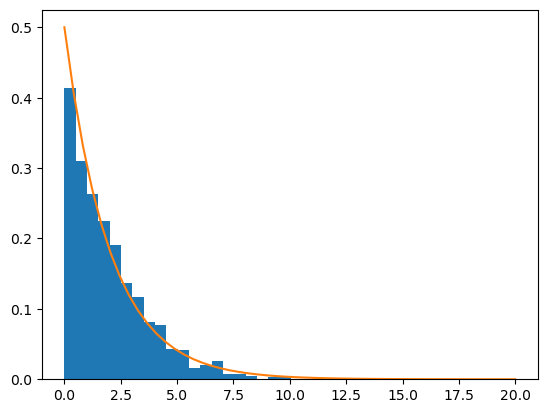

In [187]:
plt.hist((x**2+y**2)/(2/14)*2,bins=20,density=True)
plt.plot(np.linspace(0,20), chi2.pdf(np.linspace(0,20),2))

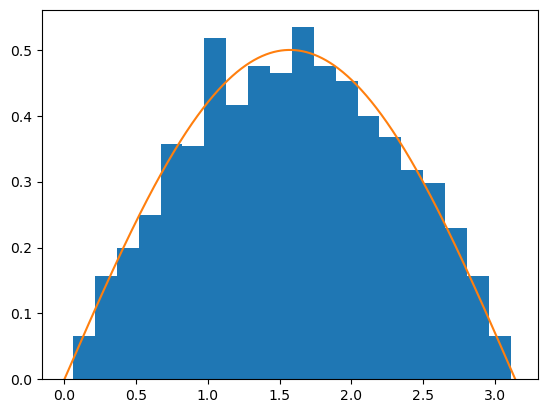

In [163]:
plt.hist(samples,bins=20,density=True)
plt.plot(np.linspace(0,np.pi,1000),custom_dist.pdf(np.linspace(0,np.pi,1000)))

(array([0.58566991, 0.56564701, 0.48054967, 0.48054967, 0.47053822,
        0.5055783 , 0.48054967, 0.51058403, 0.45552104, 0.56564701,
        0.46553249, 0.49056112, 0.49056112, 0.46553249, 0.4855554 ,
        0.52059548, 0.4855554 , 0.5055783 , 0.46553249, 0.53561265]),
 array([-9.99500418e-01, -8.99614802e-01, -7.99729186e-01, -6.99843569e-01,
        -5.99957953e-01, -5.00072337e-01, -4.00186721e-01, -3.00301104e-01,
        -2.00415488e-01, -1.00529872e-01, -6.44255591e-04,  9.92413607e-02,
         1.99126977e-01,  2.99012593e-01,  3.98898209e-01,  4.98783826e-01,
         5.98669442e-01,  6.98555058e-01,  7.98440674e-01,  8.98326291e-01,
         9.98211907e-01]),
 <BarContainer object of 20 artists>)

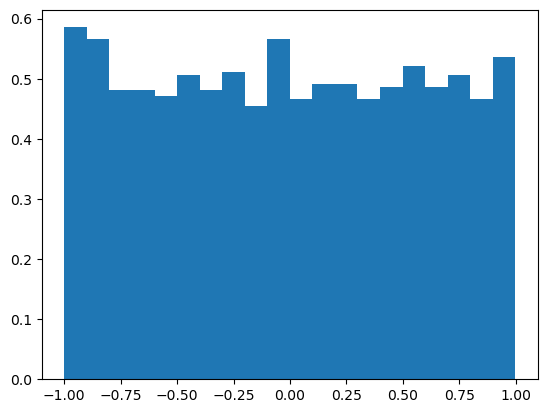

In [168]:
plt.hist(np.cos(samples),bins=20,density=True)


# Distribution along both

In [423]:
f_1_3[L][f'wf_{L}'][(0,0,-1)].shape

(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2000, 1)

In [424]:
L=8

Text(0, 0.5, '$|\\langle x | \\psi\\rangle|^2$')

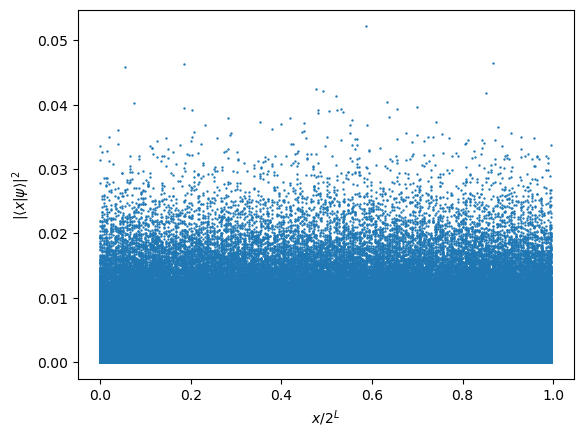

In [436]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)]).reshape((-1,2000))
x=np.arange(2**L).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x/2**L,pts.flatten(),s=0.5)

ax.set_xlabel(r'$x/2^L$')
ax.set_ylabel(r'$|\langle x | \psi\rangle|^2$')

Text(0, 0.5, '$|\\langle x | \\psi\\rangle|^2$')

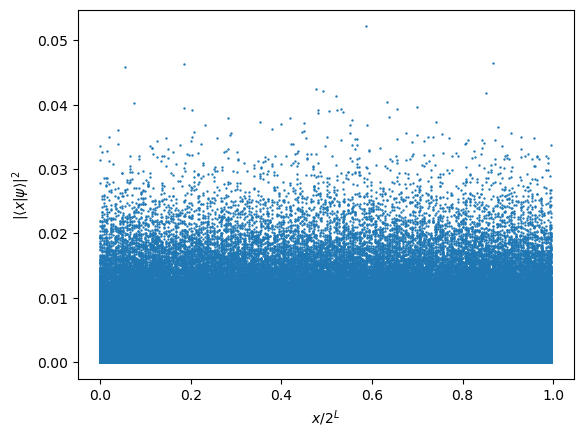

In [437]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_0[L][f'wf_{L}'][(0,0,-1)]).reshape((-1,2000))
x=np.arange(2**L).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x/2**L,pts.flatten(),s=0.5)

ax.set_xlabel(r'$x/2^L$')
ax.set_ylabel(r'$|\langle x | \psi\rangle|^2$')

Text(0, 0.5, '$|\\langle x | \\psi\\rangle|^2$')

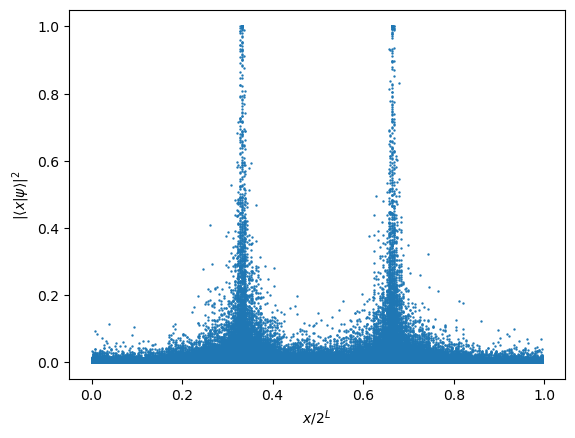

In [438]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_1_3[L][f'wf_{L}'][(10,0,-1)]).reshape((-1,2000))
x=np.arange(2**L).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x/2**L,pts.flatten(),s=0.5)

ax.set_xlabel(r'$x/2^L$')
ax.set_ylabel(r'$|\langle x | \psi\rangle|^2$')

Text(0, 0.5, '$|\\langle x | \\psi\\rangle|^2$')

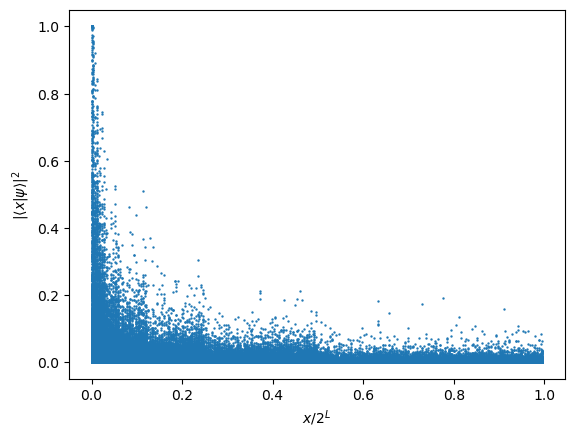

In [442]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_0[L][f'wf_{L}'][(10,0,-1)]).reshape((-1,2000))
x=np.arange(2**L).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x/2**L,pts.flatten(),s=0.5)

ax.set_xlabel(r'$x/2^L$')
ax.set_ylabel(r'$|\langle x | \psi\rangle|^2$')

Text(0, 0.5, '$|\\langle x | \\psi\\rangle|^2$')

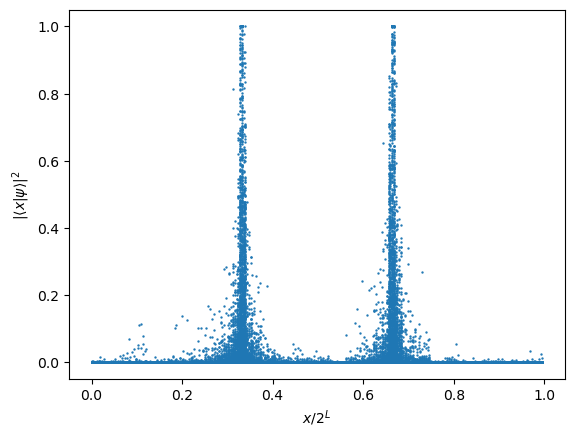

In [439]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_1_3[L][f'wf_{L}'][(15,0,-1)]).reshape((-1,2000))
x=np.arange(2**L).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x/2**L,pts.flatten(),s=0.5)

ax.set_xlabel(r'$x/2^L$')
ax.set_ylabel(r'$|\langle x | \psi\rangle|^2$')

Text(0, 0.5, '$|\\langle x | \\psi\\rangle|^2$')

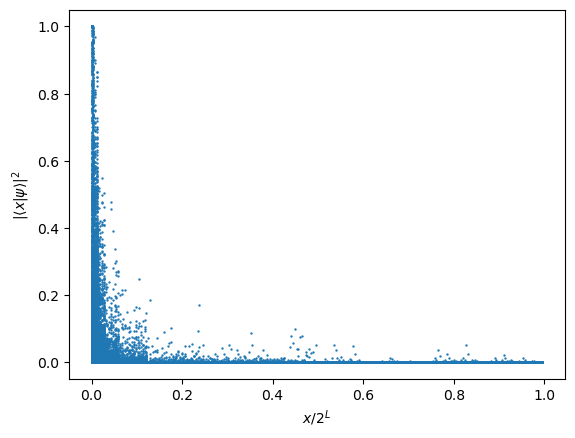

In [443]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_0[L][f'wf_{L}'][(15,0,-1)]).reshape((-1,2000))
x=np.arange(2**L).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x/2**L,pts.flatten(),s=0.5)

ax.set_xlabel(r'$x/2^L$')
ax.set_ylabel(r'$|\langle x | \psi\rangle|^2$')

Text(0, 0.5, '$|\\langle x | \\psi\\rangle|^2$')

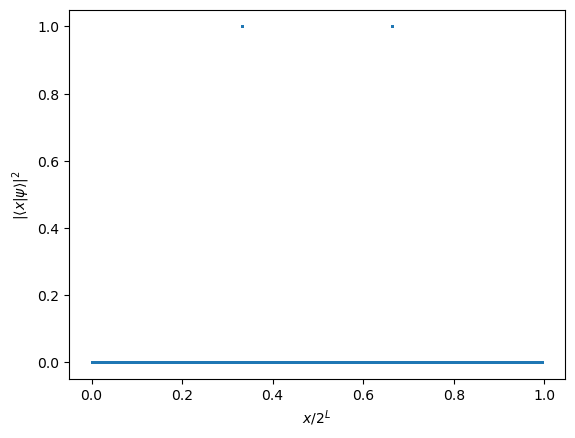

In [440]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_1_3[L][f'wf_{L}'][(20,0,-1)]).reshape((-1,2000))
x=np.arange(2**L).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x/2**L,pts.flatten(),s=0.5)

ax.set_xlabel(r'$x/2^L$')
ax.set_ylabel(r'$|\langle x | \psi\rangle|^2$')

Text(0, 0.5, '$|\\langle x | \\psi\\rangle|^2$')

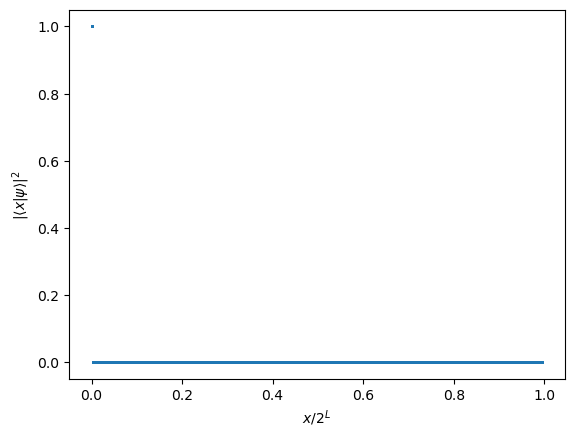

In [444]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_0[L][f'wf_{L}'][(20,0,-1)]).reshape((-1,2000))
x=np.arange(2**L).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x/2**L,pts.flatten(),s=0.5)

ax.set_xlabel(r'$x/2^L$')
ax.set_ylabel(r'$|\langle x | \psi\rangle|^2$')

Text(0, 0.5, '$\\sum_{x=FDW_k}|\\langle x | \\psi\\rangle|^2$')

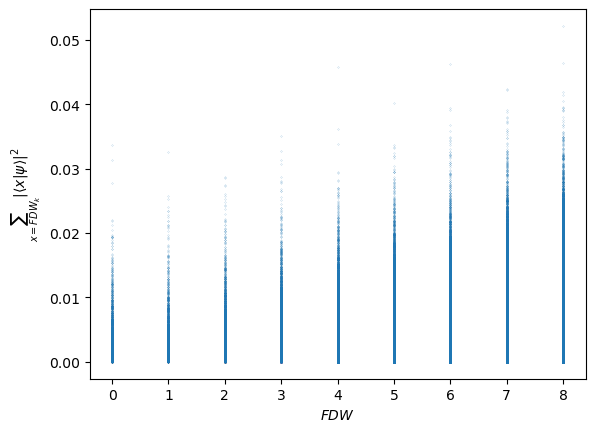

In [450]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_0[L][f'wf_{L}'][(0,0,-1)]).reshape((-1,2000))
x=np.array(convert_bitstring_to_dw(L)).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x,pts.flatten(),s=0.01)

ax.set_xlabel(r'$FDW$')
ax.set_ylabel(r'$\sum_{x=FDW_k}|\langle x | \psi\rangle|^2$')

Text(0, 0.5, '$\\sum_{x=FDW_k}|\\langle x | \\psi\\rangle|^2$')

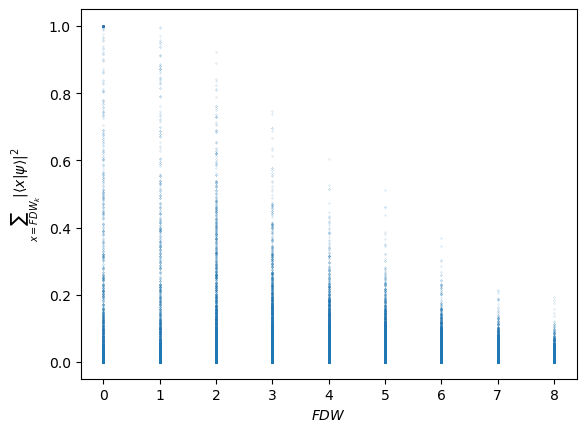

In [451]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_0[L][f'wf_{L}'][(10,0,-1)]).reshape((-1,2000))
x=np.array(convert_bitstring_to_dw(L)).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x,pts.flatten(),s=0.01)

ax.set_xlabel(r'$FDW$')
ax.set_ylabel(r'$\sum_{x=FDW_k}|\langle x | \psi\rangle|^2$')

Text(0, 0.5, '$\\sum_{x=FDW_k}|\\langle x | \\psi\\rangle|^2$')

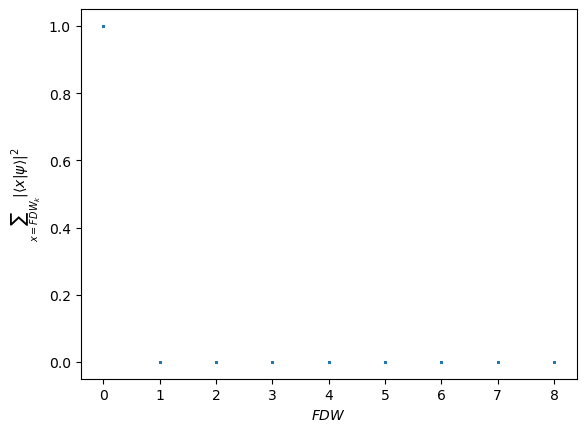

In [452]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_0[L][f'wf_{L}'][(20,0,-1)]).reshape((-1,2000))
x=np.array(convert_bitstring_to_dw(L)).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x,pts.flatten(),s=0.01)

ax.set_xlabel(r'$FDW$')
ax.set_ylabel(r'$\sum_{x=FDW_k}|\langle x | \psi\rangle|^2$')

Text(0, 0.5, '$\\sum_{x=FDW_k}|\\langle x | \\psi\\rangle|^2$')

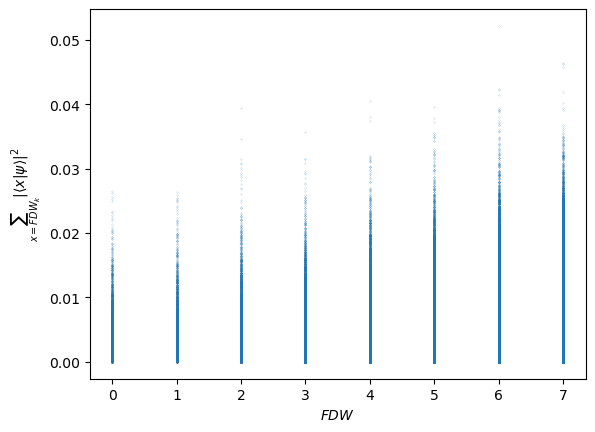

In [453]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_1_3[L][f'wf_{L}'][(0,0,-1)]).reshape((-1,2000))
x=np.array(convert_bitstring_to_dw(L,ZZ=True)).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x,pts.flatten(),s=0.01)

ax.set_xlabel(r'$FDW$')
ax.set_ylabel(r'$\sum_{x=FDW_k}|\langle x | \psi\rangle|^2$')

Text(0, 0.5, '$\\sum_{x=FDW_k}|\\langle x | \\psi\\rangle|^2$')

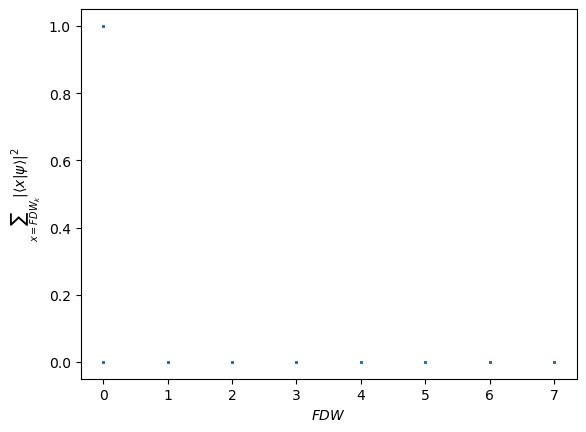

In [454]:
fig,ax=plt.subplots()
pts=convert_to_abs(f_1_3[L][f'wf_{L}'][(20,0,-1)]).reshape((-1,2000))
x=np.array(convert_bitstring_to_dw(L,ZZ=True)).repeat(2000).reshape((2**L,2000)).flatten()
ax.scatter(x,pts.flatten(),s=0.01)

ax.set_xlabel(r'$FDW$')
ax.set_ylabel(r'$\sum_{x=FDW_k}|\langle x | \psi\rangle|^2$')

In [13]:
pts=np.vstack([bitstring.flatten(),convert_to_abs(f['wf_8'][10,0,-1].reshape((-1,2000))).flatten()])

In [14]:
kernel=gaussian_kde(pts,bw_method=0.04,)

In [70]:
B,F=np.meshgrid(np.arange(0,2**8),np.linspace(0,1,11),)


In [71]:
B.shape

(11, 256)

In [72]:
Z=kernel(np.vstack([B.ravel(),F.ravel()])).reshape(B.shape)

In [73]:
Z.shape

(11, 256)

In [74]:
F[:,0]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
p_idx=10
pts=np.vstack([bitstring.flatten(),convert_to_abs(f['wf_8'][p_idx,0,-1].reshape((-1,2000))).flatten()])
plt.scatter(*pts,marker='.',s=0.01)
plt.plot(bitstring[:,0],convert_to_abs(f['wf_8'][p_idx,0,-1].reshape((-1,2000))).mean(axis=-1),color='r')
# plt.pcolormesh(B[0],F[:,0],(Z),shading='auto',cmap='Blues')

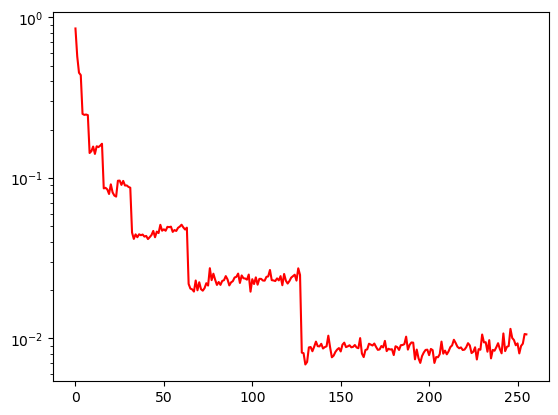

In [123]:
p_idx=9
plt.plot(bitstring[:,0],10*convert_to_abs(f['wf_8'][p_idx,0,-1].reshape((-1,2000))).mean(axis=-1),color='r')
plt.yscale('log')

In [76]:
import seaborn as sns


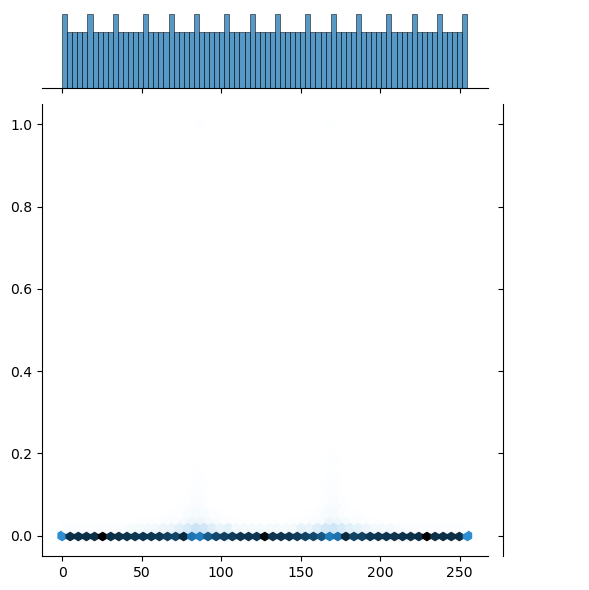

In [77]:
sns.jointplot(x=pts[0], y=pts[1], kind="hex")

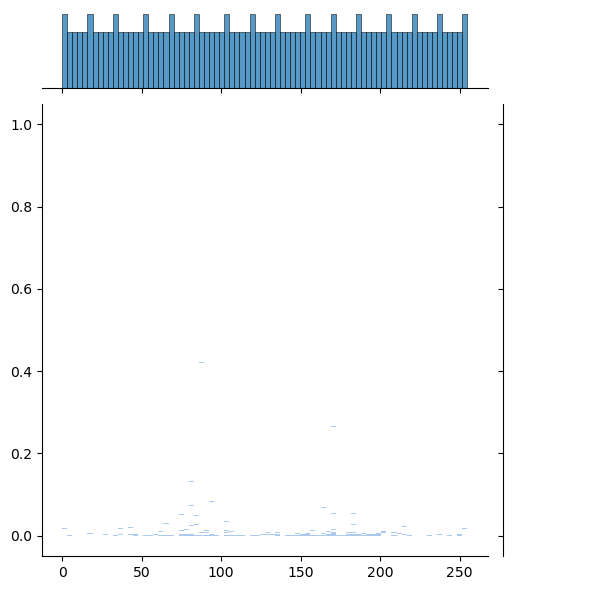

In [78]:
sns.jointplot(x=pts[0], y=pts[1], kind="hist")

In [86]:
ensemble=wf_amp[10,0,...,0].reshape((-1,2000))

In [87]:
ensemble.shape

torch.Size([256, 2000])

In [88]:
torch.arange(256).repeat(2000).reshape((2000,256)).T.flatten()
ensemble.flatten()

tensor([0.0023, 0.1159, 0.2009,  ..., 0.0000, 0.0000, 0.0000])

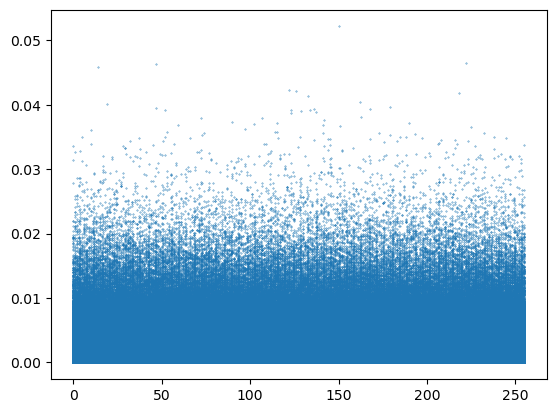

In [81]:
plt.scatter(torch.arange(256).repeat(2000).reshape((2000,256)).T.flatten(),ensemble.flatten(),s=0.1)

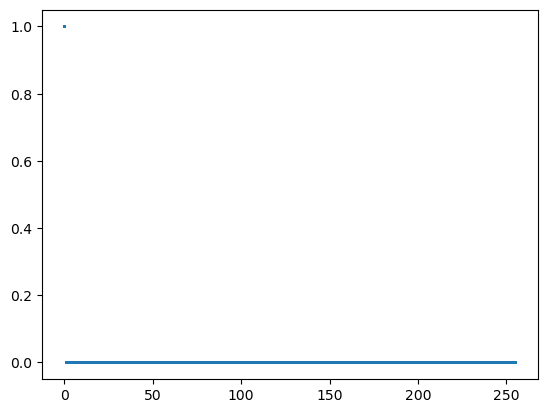

In [85]:
plt.scatter(torch.arange(256).repeat(2000).reshape((2000,256)).T.flatten(),ensemble.flatten(),s=0.1)

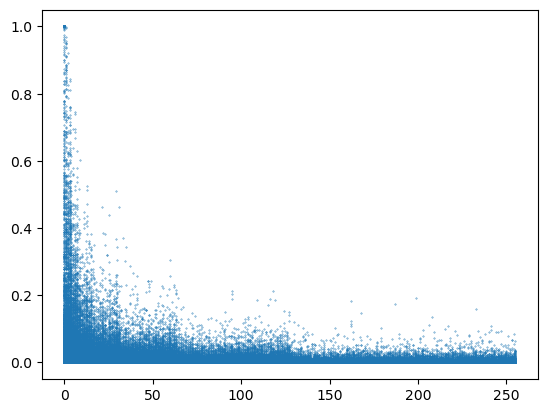

In [89]:
plt.scatter(torch.arange(256).repeat(2000).reshape((2000,256)).T.flatten(),ensemble.flatten(),s=0.1)

In [80]:
ensemble[0,]

torch.Size([256, 2000])

# A vs L 

In [13]:
A_list_0=([[convert_to_abs(f_0[L][f'wf_{L}'][(p_idx,0,-1)+(0,)*L]).mean(axis=(-2,-1)) for p_idx in range(21)] for L in L_list])
A_list_1_3=([[convert_to_abs(f_1_3[L][f'wf_{L}'][(p_idx,0,-1)+(0,1)*(L//2)]).mean(axis=(-2,-1)) + convert_to_abs(f_1_3[L][f'wf_{L}'][(p_idx,0,-1)+(1,0)*(L//2)]).mean(axis=(-2,-1)) for p_idx in range(21)] for L in L_list])

## p(x) dx

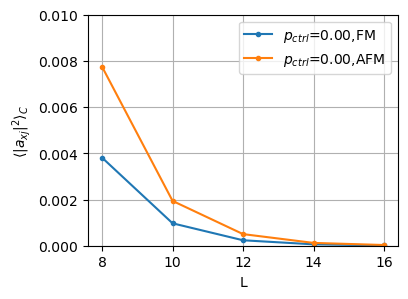

In [14]:
fig,ax=plt.subplots(figsize=(4,3))

for p_idx in [0,]:
    ax.plot(L_list, [(A_list_0[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

for p_idx in [0,]:
    ax.plot(L_list, [(A_list_1_3[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')

ax.set_xlabel('L')
ax.set_ylabel(r'$\langle|a_{xj}|^2\rangle_C$')
ax.set_xticks(L_list)
ax.grid('on')
ax.set_ylim(0,0.01)

ax.legend()

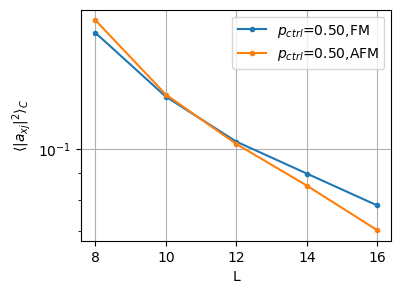

In [21]:
fig,ax=plt.subplots(figsize=(4,3))

for p_idx in [10,]:
    ax.plot(L_list, [(A_list_0[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

for p_idx in [10,]:
    ax.plot(L_list, [(A_list_1_3[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')

ax.set_xlabel('L')
ax.set_ylabel(r'$\langle|a_{xj}|^2\rangle_C$')
# ax.set_xticks(1/L_list)
ax.grid('on')
ax.legend()
ax.set_yscale('log')

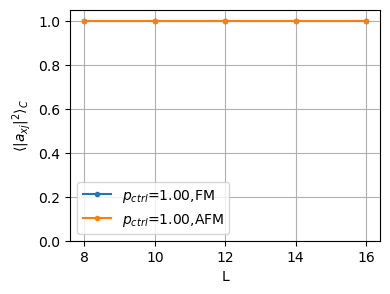

In [16]:
fig,ax=plt.subplots(figsize=(4,3))

for p_idx in [20,]:
    ax.plot(L_list, [(A_list_0[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

for p_idx in [20,]:
    ax.plot(L_list, [(A_list_1_3[L_idx][p_idx]) for L_idx in range(len(L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')

ax.set_xlabel('L')
ax.set_ylabel(r'$\langle|a_{xj}|^2\rangle_C$')
ax.set_xticks(L_list)
ax.grid('on')
ax.set_ylim(0,1.05)
ax.legend()

## p(x)

(0.0, 2.1)

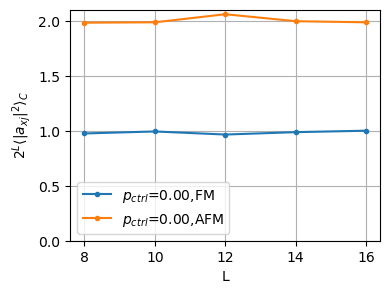

In [23]:
fig,ax=plt.subplots(figsize=(4,3))

for p_idx in [0,]:
    ax.plot(L_list, [2**L*(A_list_0[L_idx][p_idx]) for L_idx,L in enumerate((L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

for p_idx in [0,]:
    ax.plot(L_list, [2**L*(A_list_1_3[L_idx][p_idx]) for L_idx,L in enumerate((L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')
ax.set_xlabel('L')
ax.set_ylabel(r'$2^L\langle|a_{xj}|^2\rangle_C$')
ax.set_xticks(L_list)
ax.grid('on')
ax.legend()

ax.set_ylim(0,2.1)


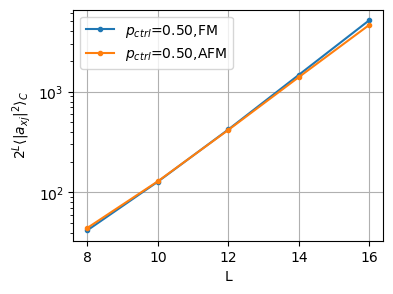

In [24]:
fig,ax=plt.subplots(figsize=(4,3))

for p_idx in [10,]:
    ax.plot(L_list, [2**L*(A_list_0[L_idx][p_idx]) for L_idx,L in enumerate((L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

for p_idx in [10,]:
    ax.plot(L_list, [2**L*(A_list_1_3[L_idx][p_idx]) for L_idx,L in enumerate((L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')
ax.set_xlabel('L')
ax.set_ylabel(r'$2^L\langle|a_{xj}|^2\rangle_C$')
# ax.set_xticks(1/L_list)
ax.grid('on')
ax.legend()
ax.set_yscale('log')

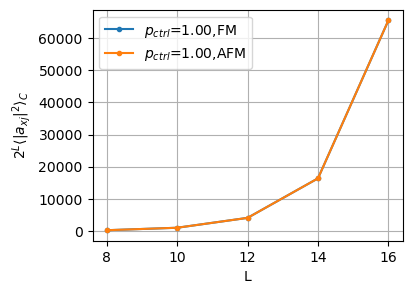

In [25]:
fig,ax=plt.subplots(figsize=(4,3))

for p_idx in [20,]:
    ax.plot(L_list, [2**L*(A_list_0[L_idx][p_idx]) for L_idx,L in enumerate((L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},FM')

for p_idx in [20,]:
    ax.plot(L_list, [2**L*(A_list_1_3[L_idx][p_idx]) for L_idx,L in enumerate((L_list))],'.-',label=f'$p_{{ctrl}}$={p_ctrl_list[p_idx]:.2f},AFM')
ax.set_xlabel('L')
ax.set_ylabel(r'$2^L\langle|a_{xj}|^2\rangle_C$')
ax.set_xticks(L_list)
ax.grid('on')
ax.legend()

# Diffusion constant

In [5]:
import scipy

In [6]:
p_proj_list=np.linspace(0,1,21)

In [7]:
def convert_bitstring_to_dw(L,ZZ=False):
    # The distance of the leftmost "1" to the right
    dw=[]
    for bitstring in range(2**L):
        pos=L-1
        if ZZ:
            bitstring=~(bitstring^(bitstring>>1))
            pos-=1
        while pos>-1 and bitstring&(1<<pos)==0:
            pos-=1
        dw.append(pos+1)
    return dw

In [8]:
L_list=[8,10,12,14,16]
f_1_3_t={}
for L in L_list:
    f_1_3_t[L]=h5py.File(f'CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,1.00,21)_L({L},{L+2},2)_xj(1-3,2-3)_seed0_64_wf_T.hdf5')

In [51]:
L_list=[8,10,12,14,16]
f_0_t={}
for L in L_list:
    f_0_t[L]=h5py.File(f'CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,1.00,21)_L({L},{L+2},2)_xj(0)_seed0_64_wf_T.hdf5')

Text(0, 0.5, '$\\langle (r-\\langle r \\rangle)^2 \\rangle$')

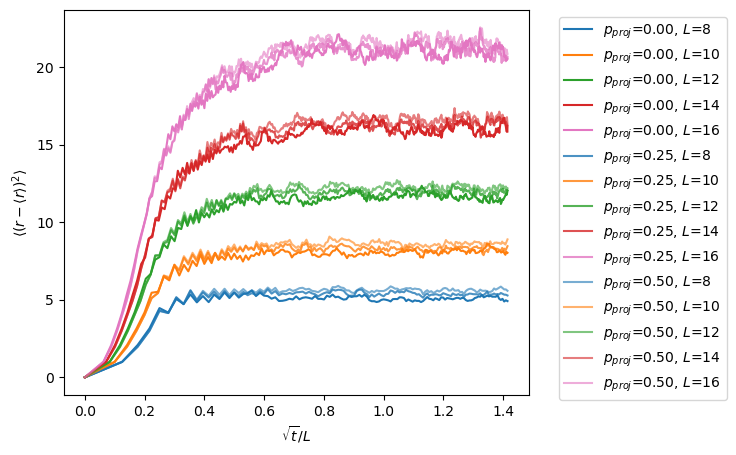

In [76]:
fig,ax=plt.subplots(figsize=(6,5))
for idx,alpha in zip([0,5,10,],[1,0.8,0.6]):
    for L,color in zip([8,10,12,14,16],['C0','C1','C2','C3','C6']):
        ax.plot(np.sqrt(np.arange(2*L**2+1))/L,np.var(f_0_t[L][f'FDW_{L}'],axis=-2)[0,idx,:,0],label=f'$p_{{proj}}$={p_proj_list[idx]:.2f}, $L$={L}',color=color,alpha=alpha)

# ax.set_xlim(0,30)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel(r'$\sqrt{t}/L$')
ax.set_ylabel(r'$\langle (r-\langle r \rangle)^2 \rangle$')

Text(0, 0.5, '$\\langle (r-\\langle r \\rangle)^2 \\rangle$')

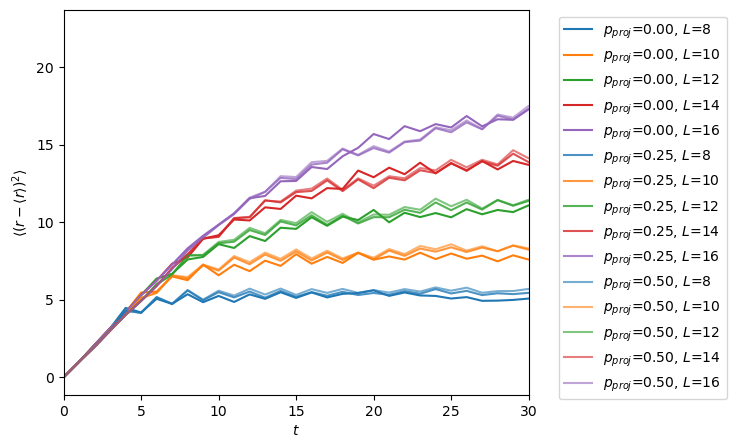

In [63]:
fig,ax=plt.subplots(figsize=(6,5))
for idx,alpha in zip([0,5,10,],[1,0.8,0.6]):
    for L,color in zip([8,10,12,14,16],['C0','C1','C2','C3','C6']):
        ax.plot(np.var(f_0_t[L][f'FDW_{L}'],axis=-2)[0,idx,:,0],label=f'$p_{{proj}}$={p_proj_list[idx]:.2f}, $L$={L}',color=color,alpha=alpha)

ax.set_xlim(0,30)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\langle (r-\langle r \rangle)^2 \rangle$')

Text(0, 0.5, '$\\langle r \\rangle$')

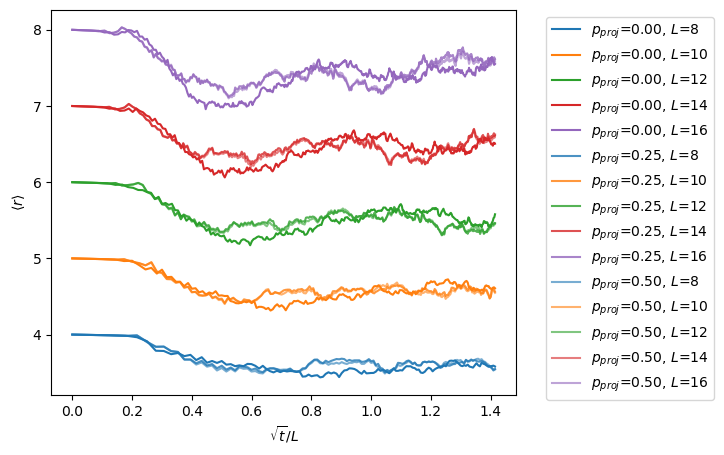

In [68]:
fig,ax=plt.subplots(figsize=(6,5))
for idx,alpha in zip([0,5,10,],[1,0.8,0.6]):
    for L,color in zip([8,10,12,14,16],['C0','C1','C2','C3','C6']):
        ax.plot(np.sqrt(np.arange(2*L**2+1))/L,np.mean(f_0_t[L][f'FDW_{L}'],axis=-2)[0,idx,:,0],label=f'$p_{{proj}}$={p_proj_list[idx]:.2f}, $L$={L}',color=color,alpha=alpha)

# ax.set_xlim(0,30)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel(r'$\sqrt{t}/L$')
ax.set_ylabel(r'$\langle r \rangle$')

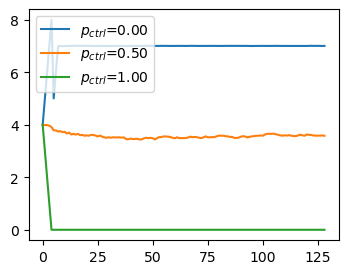

In [373]:
fig,ax=plt.subplots(figsize=(4,3))
for idx in [0,10,20]:
    ax.plot([convert_to_abs(f_0_t[8][f'wf_{8}'][(idx,0,t)].reshape((-1,2000))).mean(axis=-1)@dw_0 for t in range(2*8**2+1)],label=f'$p_{{ctrl}}$={p_ctrl_list[idx]:.2f}')
ax.legend()

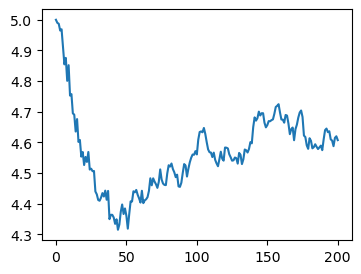

In [20]:
fig,ax=plt.subplots(figsize=(4,3))
for idx in [0,]:
    for L in [10,]:
        ax.plot(np.mean(f_0_t[L][f'FDW_{L}'],axis=-2)[0,idx,:,0],label=f'$p_{{ctrl}}$={p_proj_list[idx]:.2f}, $L$={L}')

# ax.set_xlim(0,30)
# ax.legend()

In [75]:
rt_0_var=lambda idx: [dw_0@convert_to_abs(f_0_t[10][f'wf_{10}'][(0,idx,t)].reshape((-1,2000))) for t in range(2*10**2+1)]

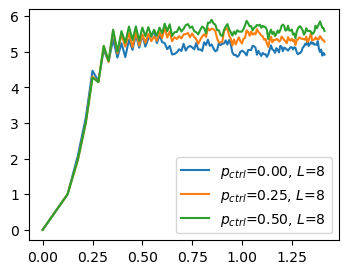

In [26]:
fig,ax=plt.subplots(figsize=(4,3))
for idx in [0,5,10,]:
    for L in [8,]:
        ax.plot(np.sqrt(np.arange(2*L**2+1))/L,np.var(f_0_t[L][f'FDW_{L}'],axis=-2)[0,idx,:,0],label=f'$p_{{ctrl}}$={p_proj_list[idx]:.2f}, $L$={L}')

# ax.set_xlim(0,30)
ax.legend()

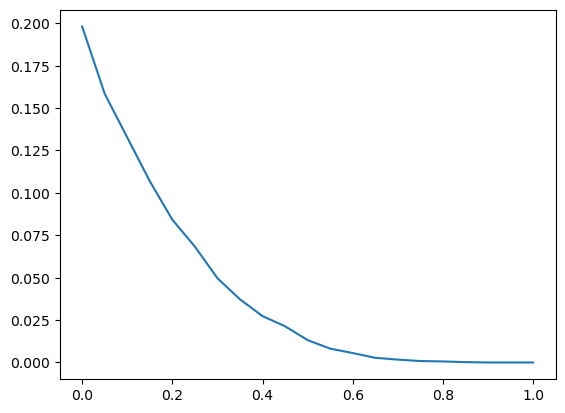

In [59]:
plt.plot(p_proj_list,np.mean(f_0_t[8]['EE'],axis=(0,2,3,4)))

In [331]:
zz=f_1_3_t[8][f'wf_{8}'][(0,0,-1)].reshape((-1,2000))[:,10]

In [332]:
convert_to_abs(zz)@dw_1_3

6.051292851912752

In [28]:
rt_1_3= lambda idx: [convert_to_abs(f_1_3_t[8][f'wf_{8}'][(0,idx,t)].reshape((-1,2000))).mean(axis=-1)@dw_1_3 for t in range(2*8**2+1)]

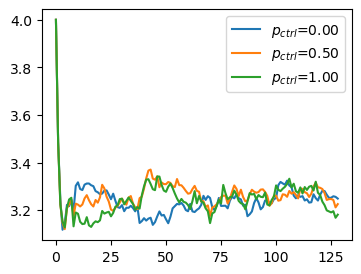

In [55]:
fig,ax=plt.subplots(figsize=(4,3))
for idx in [0,10,20]:
    # [convert_to_abs(f_1_3_t[8][f'wf_{8}'][(idx,0,t)].reshape((-1,2000))).mean(axis=-1)@dw_1_3 for t in range(2*8**2+1)]
    ax.plot(rt_1_3(idx),label=f'$p_{{ctrl}}$={p_proj_list[idx]:.2f}')
ax.legend()

In [348]:
dw_1_3@convert_to_abs(f_1_3_t[8][f'wf_{8}'][(10,0,t)].reshape((-1,2000))).shape

array([5.30674458, 2.97785249, 1.934388  , ..., 5.08430906, 1.5926069 ,
       3.80196463])

In [68]:
rt_1_3_var=lambda idx: [dw_1_3@convert_to_abs(f_1_3_t[10][f'wf_{10}'][(0,idx,t)].reshape((-1,2000))) for t in range(2*10**2+1)]

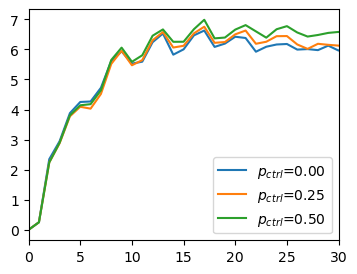

In [71]:
fig,ax=plt.subplots(figsize=(4,3))
for idx in [0,5,10,]:
    ax.plot(np.vstack(rt_1_3_var(idx)).var(axis=1),label=f'$p_{{ctrl}}$={p_proj_list[idx]:.2f}')
ax.set_xlim(0,30)
ax.legend()

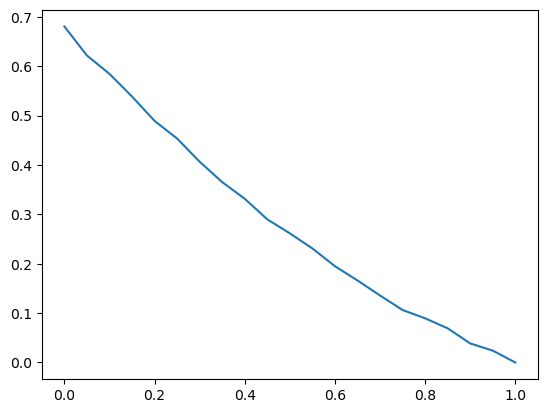

In [53]:
plt.plot(p_proj_list,np.mean(f_1_3_t[8]['EE'],axis=(0,2,3,4)))

In [82]:
f_1_3_t[8]['FDW_8'].shape

(1, 21, 129, 2000, 1)

In [84]:
np.var(f_1_3_t[8]['FDW_8'],axis=-2)

(1, 21, 129, 1)

Text(0, 0.5, '$\\langle (r-\\langle r \\rangle)^2 \\rangle$')

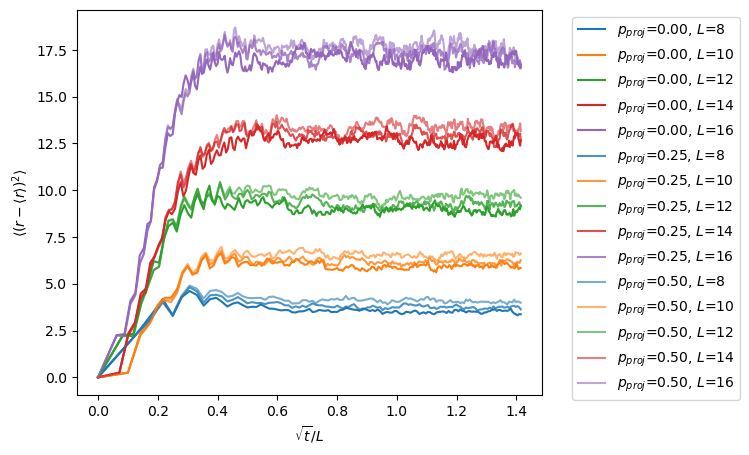

In [57]:
fig,ax=plt.subplots(figsize=(6,5))
for idx,alpha in zip([0,5,10,],[1,0.8,0.6]):
    for L,color in zip([8,10,12,14,16],['C0','C1','C2','C3','C6']):
        ax.plot(np.sqrt(np.arange(2*L**2+1))/L,np.var(f_1_3_t[L][f'FDW_{L}'],axis=-2)[0,idx,:,0],label=f'$p_{{proj}}$={p_proj_list[idx]:.2f}, $L$={L}',color=color,alpha=alpha)

# ax.set_xlim(0,30)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel(r'$\sqrt{t}/L$')
ax.set_ylabel(r'$\langle (r-\langle r \rangle)^2 \rangle$')

Text(0, 0.5, '$\\langle (r-\\langle r \\rangle)^2 \\rangle$')

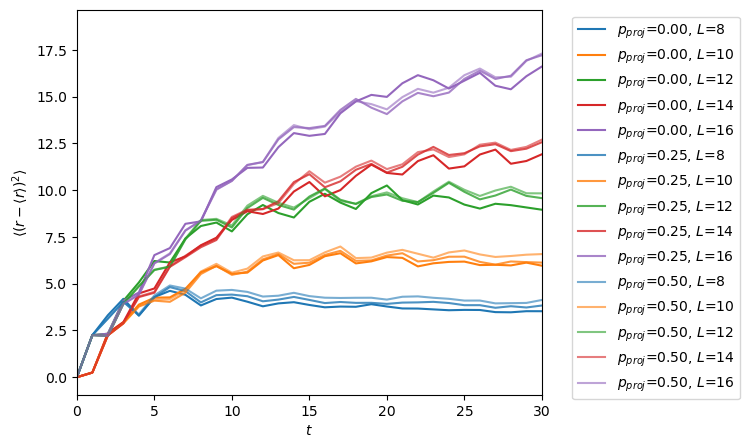

In [62]:
fig,ax=plt.subplots(figsize=(6,5))
for idx,alpha in zip([0,5,10,],[1,0.8,0.6]):
    for L,color in zip([8,10,12,14,16],['C0','C1','C2','C3','C6']):
        ax.plot(np.var(f_1_3_t[L][f'FDW_{L}'],axis=-2)[0,idx,:,0],label=f'$p_{{proj}}$={p_proj_list[idx]:.2f}, $L$={L}',color=color,alpha=alpha)

ax.set_xlim(0,30)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\langle (r-\langle r \rangle)^2 \rangle$')

Text(0, 0.5, '$\\langle r \\rangle$')

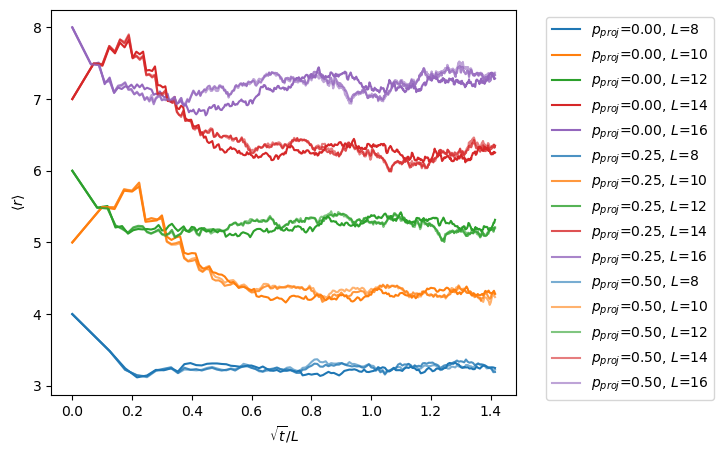

In [67]:
fig,ax=plt.subplots(figsize=(6,5))
for idx,alpha in zip([0,5,10,],[1,0.8,0.6]):
    for L,color in zip([8,10,12,14,16],['C0','C1','C2','C3','C6']):
        ax.plot(np.sqrt(np.arange(2*L**2+1))/L,np.mean(f_1_3_t[L][f'FDW_{L}'],axis=-2)[0,idx,:,0],label=f'$p_{{proj}}$={p_proj_list[idx]:.2f}, $L$={L}',color=color,alpha=alpha)

# ax.set_xlim(0,30)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel(r'$\sqrt{t}/L$')
ax.set_ylabel(r'$\langle r \rangle$')

In [161]:
np.var(f_1_3_t[L][f'FDW_{L}'],axis=-2)[0,:L,:,0].shape

(14, 393)

In [184]:
L=14

In [69]:
def diffusion_coef(f_t,p_proj_idx,L):
    y=np.var(f_t[L][f'FDW_{L}'],axis=-2)[0,p_proj_idx,:L,0]
    x=np.arange(len(y))
    res=scipy.stats.linregress(x,y)
    return res.slope,res.stderr

In [71]:
diffusion_1_3={L:np.array([diffusion_coef(f_1_3_t,p_proj_idx,L) for p_proj_idx in range(21)]) for L in L_list}
EE_1_3={L:[np.mean(f_1_3_t[L]['EE'],axis=(0,2,3,4))[p_proj_idx] for p_proj_idx in range(21)] for L in L_list}

Text(0, 0.5, '$\\overline{S_{L/2}}$')

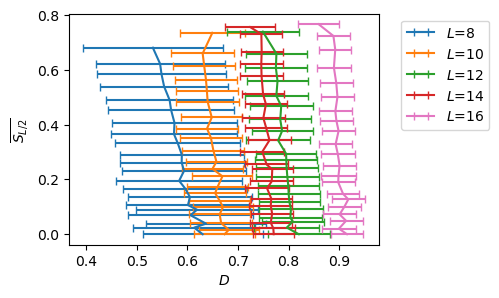

In [75]:
fig,ax=plt.subplots(figsize=(4,3))
for L,color in zip([8,10,12,14,16],['C0','C1','C2','C3','C6']):
    ax.errorbar(diffusion_1_3[L][:,0],EE_1_3[L],xerr=diffusion_1_3[L][:,1],label=f'$L$={L}',capsize=3,color=color)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel(r'$D$')
ax.set_ylabel(r'$\overline{S_{L/2}}$')

In [66]:
(dw_0@convert_to_abs(f_0[8][f'wf_{8}'][(-1,0,-1)].reshape((-1,2000)))).mean()

0.0

In [75]:
convert_to_abs(f_0[8][f'wf_{8}'][(-1,0,-1)].reshape((-1,2000))).mean(axis=-1)@dw_0

0.0

In [109]:
0b0000000010000000/2**16

0.001953125

In [89]:
from rqc.utils import dec2bin

In [110]:
bin(dec2bin(0b0000000010000000/2**16,L=16))

'0b10000000'

In [111]:
dec2bin(0b0000000010000000/2**16,L=16)-0b0000000010000000

0